# Figure generation for "Length Biases..."

This notebook generates all figures in the body and supplement of "Length Biases in Single-Cell RNA Sequencing of pre-mRNA" based on pre-computed results from *Monod*.

## Prerequisites

In [1]:
import sys
sys.path.insert(0, '/home/ggorin/projects/monod/src/')

In [2]:
import monod
from monod import preprocess, extract_data, cme_toolbox, inference, analysis

In [141]:
import pandas as pd
import numpy as np
import loompy as lp
import matplotlib
import matplotlib.pyplot as plt
import scipy

In [11]:
spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

In [19]:
dict_locations = ['../polyA_ref/' + x for x in ['gg_200525_genome_polyA_cum_3','gg_200524_mouse_genome_polyA_cum_1']]
transcriptome_dicts = [monod.preprocess.get_transcriptome(x) for x in dict_locations] #human then mouse

In [1367]:
from matplotlib.colors import ListedColormap

c1 = [173/255,214/255,200/255]
c2 = [59/255,131/255,130/255]
ncol=50
cmap_histogram = ListedColormap(np.array([np.linspace(c2[j],c1[j],ncol) for j in range(3)]).T)

c1 = [0,0,0,0]
# c2 = [1,1,1,1]
c2 = [235/255,228/255,143/255,1]
ncol=2
cmap_highlight_landscape = ListedColormap(np.array([np.linspace(c2[j],c1[j],ncol) for j in range(4)]).T)


aesthetics = \
    {'selected_markersize_body':2.2,'omitted_markersize_body':1.8,
     'selected_markersize_supp':2.2,'selected_markersize_supp':1.8,
     'selected_color':np.array([212,107,75])/255,
     'omitted_color':'lightgray',
     'selected_alpha':0.3,'omitted_alpha':0.1,'fontsize_body_axes':14,'fontsize_body_title':16,
     'pmf_colormap':cmap_histogram,
     'landscape_colormap':cmap_histogram,
     'landscape_highlight_colormap':cmap_highlight_landscape,
     'optimum_color':[212/255,107/255,75/255],
     'optimum_markersize':100,
     'highlighted_optimum_markersize':300,
     'dataset_colors':('violet','darkorchid','rebeccapurple','midnightblue'),
     "accepted_gene_color": [203/255,197/255,149/255],
     "rejected_gene_color": "darkgrey",
     "accepted_gene_alpha": 0.4,
     "rejected_gene_alpha": 0.5,
     "accepted_gene_ms": 5,
     "rejected_gene_ms": 5,
     'hist_face_color':'lightgray',
     "hist_fit_color":  [59/255,131/255,130/255],
     "hist_fit_lw": 3,
     'identity_line_color':[212/255,107/255,75/255],
     'identity_lw':3,
     'v2_gene_color':[39/255]*3,
     'celltype_diffs_gene_color':[39/255]*3,
     'celltype_colors':('orange','teal','mediumvioletred'),
     'celltype_marker_alpha':0.8,
     'celltype_diffs_gene_alpha':0.3,
     'celltype_diffs_ms':4,
     'celltype_marker_ms':60,
     'partition_line_color':'forestgreen'
}

In [78]:
figdir = './figs'

In [755]:
# batch_dirs = ['gg_221118_025_pbmc_1','gg_221115_025_heart_1','gg_221116_025_neuron_1','gg_221116_025_allen_tech_1']
batch_dirs = ['gg_221118_025_pbmc_1','gg_221115_025_heart_1','gg_221116_025_neuron_1','gg_221118_025_allen_1']
 
dataset_v3_list = [['pbmc_1k_v3','pbmc_10k_v3'],
                     ['heart_1k_v3','heart_10k_v3'],
                     ['neuron_1k_v3','neuron_10k_v3'],
                     ['allen_'+x for x in ['B08','C01','F08','H12','B01','A01']]]
#                      ['allen_'+x for x in ['B08','C01','F08','H12','C01','G12']]]
dataset_v2_list = ['pbmc_1k_v2','heart_1k_v2','neuron_1k_v2','allen_B05']

dataset_name_list = [['pbmc_1k_v2','pbmc_1k_v3','pbmc_10k_v3'],
                     ['heart_1k_v2','heart_1k_v3','heart_10k_v3'],
                     ['neuron_1k_v2','neuron_1k_v3','neuron_10k_v3'],
                     ['allen_'+x for x in ['B05','B08','C01','F08','H12','B01','A01']]]
#                      ['allen_'+x for x in ['B05','B08','C01','F08','H12','C01','G12']]]

tenX_dir = '/home/ggorin/count_data/loom_10x_kb/'
allen_dir = '/home/ggorin/count_data/loom_allen_kb/'
raw_looms = [[tenX_dir+x+'.loom' for x in dataset_name_list[0]], \
            [tenX_dir+x+'.loom' for x in dataset_name_list[1]], \
            [tenX_dir+x+'.loom' for x in dataset_name_list[2]], \
            [allen_dir+x+'_raw.loom' for x in dataset_name_list[3]]]

batch_names = ['pbmc','heart','neuron','allen']
tech_replicate_pairs = [[[0,1]],[[0,1]],[[0,1]],[[1,4],[3,5]]]
bio_replicate_pairs = [[],[],[],[[0,1],[1,2],[2,3],[0,2],[0,3]]]
tech_v2_replicate_pairs = [[0,2],[0,2],[0,2],[0,5]]



In [1125]:
batch_dirs_noisefree =  ['gg_221119_025_pbmc_noisefree_1',\
                         'gg_221119_025_heart_noisefree_1',\
                         'gg_221119_025_neuron_noisefree_1',\
                         'gg_221119_025_allen_noisefree_1']

In [1198]:
pbmc_celltype_dataset = dataset_v3_list[0][1]
pbmc_baseline_dir = batch_dirs[0]
pbmc_celltype_batch_dir = 'gg_221118_025_pbmc_celltypes_1'
pbmc_celltype_names = ['Tcells','Monocytes','Bcells']
pbmc_celltype_names_labels = ['T cells','monocytes','B cells']
pbmc_celltypes = [pbmc_celltype_dataset + '_' + x for x in pbmc_celltype_names]
pbmc_markers = [['CD3D', 'CD3G','CD3E','CD247','CD2','TCF7','CD4','CD69','CCL5'],
      ['CD93','CSTA','FPR1','CD14','CD36'],
      ['CD79A','CD22','BLK','IGHD','VPREB3']]


In [1199]:
pbmc_celltypes

['pbmc_10k_v3_Tcells', 'pbmc_10k_v3_Monocytes', 'pbmc_10k_v3_Bcells']

In [1347]:
allen_celltype_datasets = dataset_v3_list[3][:4]
allen_celltype_batch_dir = 'gg_221119_025_allen_celltypes_1'
allen_celltype_names = ['Glutamatergic','GABAergic']
allen_celltype_names_labels = ['glutamatergic','GABAergic']
allen_celltypes = [[dataset + '_' + celltype for celltype in allen_celltype_names] for dataset in allen_celltype_datasets]
allen_markers = [['Slc17a7','Slc17a6'],
      ['Gad1', 'Gad2', 'Slc32a1','Slc6a5']]
#       ['Gad1', 'Gad2', 'Slc32a1','Slc6a5']]
# allen_markers = [['Slc17a7', 'Grina', 'Gria3', 'Grm1', 'Grm5', 'Slc17a6'],
#       ['Gad1', 'Gad2', 'Gabra3', 'Slc32a1', 'Slc6a1', 'Slc6a5']]


In [1201]:
allen_celltypes

[['allen_B08_Glutamatergic', 'allen_B08_GABAergic'],
 ['allen_C01_Glutamatergic', 'allen_C01_GABAergic'],
 ['allen_F08_Glutamatergic', 'allen_F08_GABAergic'],
 ['allen_H12_Glutamatergic', 'allen_H12_GABAergic']]

In [1132]:
param_names = ['Burst size','Splicing rate','Degradation rate']


## Fig. 1: the naive noise-free model

In [902]:
def plot_spliced_unspliced_means(dataset_names,transcriptomes,gene_lists,filename,figsize=(12,6)):
    fig1, ax1 = plt.subplots(nrows=2,ncols=len(dataset_names),figsize=figsize)

    for k in range(len(dataset_names)):
        loom_filepath = loom_filepaths[k]
        dataset_name = dataset_names[k]
        feat_dict = transcriptomes[k]


        layers,gene_names,nCells = monod.preprocess.import_vlm(loom_filepath,attribute_names)

        U_mean = layers[0].mean(1)
        S_mean = layers[1].mean(1)

        ann_filt = monod.preprocess.identify_annotated_genes(gene_names,feat_dict)
        U_mean,S_mean,gene_names = monod.preprocess.filter_by_gene(ann_filt,U_mean,S_mean,gene_names)
        len_arr = np.asarray([feat_dict[x] for x in gene_names])



        ax1[0,k].set_title(dataset_name,fontsize=aesthetics['fontsize_body_title'])

        gf = np.isin(gene_names,gene_lists[k])

        ax1[0,k].scatter(len_arr[~gf],S_mean[~gf],s=aesthetics['omitted_markersize_body'],c=aesthetics['omitted_color'],
                        alpha=aesthetics['omitted_alpha'])
        ax1[0,k].scatter(len_arr[gf],S_mean[gf],s=aesthetics['selected_markersize_body'],c=aesthetics['selected_color'],
                        alpha=aesthetics['selected_alpha'])

        ax1[1,k].scatter(len_arr[~gf],U_mean[~gf],s=aesthetics['omitted_markersize_body'],c=aesthetics['omitted_color'],
                        alpha=aesthetics['omitted_alpha'])
        ax1[1,k].scatter(len_arr[gf],U_mean[gf],s=aesthetics['selected_markersize_body'],c=aesthetics['selected_color'],
                        alpha=aesthetics['selected_alpha'])

        ax1[0,k].set_xscale('log')
        ax1[0,k].set_yscale('log')
        ax1[1,k].set_xscale('log')
        ax1[1,k].set_yscale('log')
        if k==0:
            ax1[0,k].set_ylabel(r'Mean spliced',fontsize=aesthetics['fontsize_body_axes'])
            ax1[1,k].set_ylabel(r'Mean unspliced',fontsize=aesthetics['fontsize_body_axes'])
        ax1[1,k].set_xlabel(r'Gene length',fontsize=aesthetics['fontsize_body_axes'])

    fig1.tight_layout()
    fig1.savefig(figdir+'/'+filename+'.png',dpi=600)


### Panel a: trends in gene length and mean counts

In [903]:
dataset_names = ['pbmc_1k_v3','heart_1k_v3','neuron_1k_v3']
loom_filepaths = ['/home/ggorin/count_data/loom_10x_kb/'+x+'.loom' for x in dataset_names]
transcriptomes = [transcriptome_dicts[0]] + [transcriptome_dicts[1]]*2

In [904]:
gene_list_filepaths = ['./fits/'+x+'/genes.csv' for x in batch_dirs[:3]]
gene_lists = [list(pd.read_csv(x,header=None).iloc[0]) for x in gene_list_filepaths]

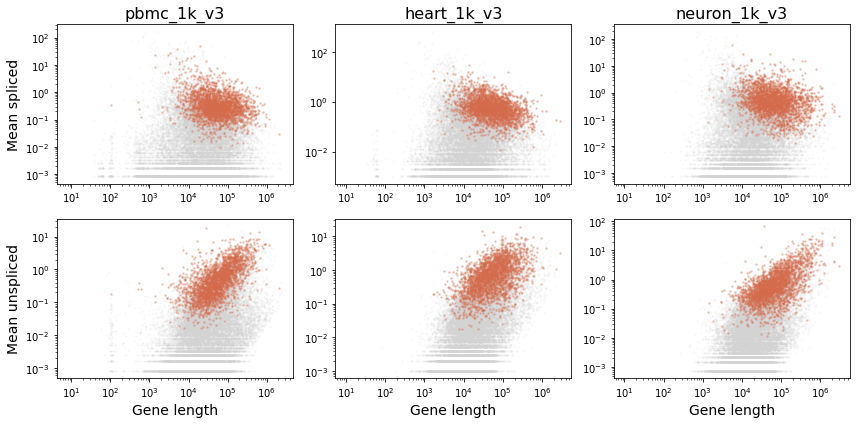

In [905]:
plot_spliced_unspliced_means(dataset_names,transcriptomes,gene_lists,'expression_bias_subset')

### Supplements to 1a

#### PBMC

In [906]:
dataset_names = dataset_name_list[0]
# dataset_names = ['pbmc_1k_v2','pbmc_1k_v3','pbmc_10k_v3']
loom_filepaths = ['/home/ggorin/count_data/loom_10x_kb/'+x+'.loom' for x in dataset_names]
transcriptomes = [transcriptome_dicts[0]]*3
gene_list_filepaths = ['./fits/'+x+'/genes.csv' for x in [batch_dirs[0]]*3]
gene_lists = [list(pd.read_csv(x,header=None).iloc[0]) for x in gene_list_filepaths]

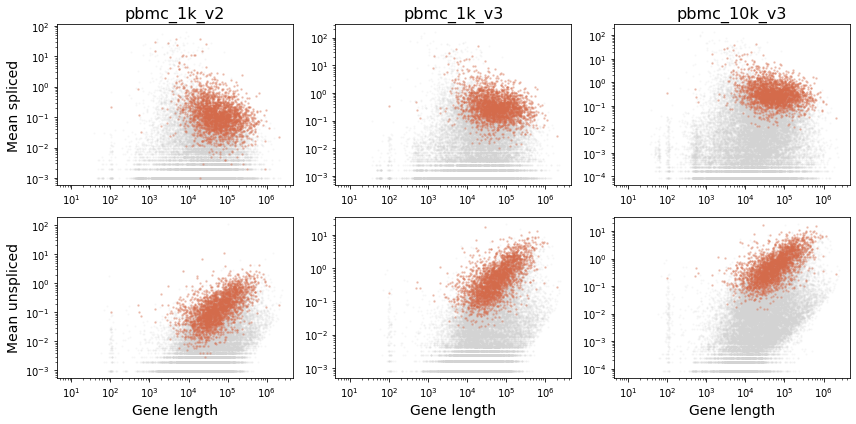

In [907]:
plot_spliced_unspliced_means(dataset_names,transcriptomes,gene_lists,'expression_bias_pbmc')

#### Heart

In [908]:
dataset_names = dataset_name_list[1]
loom_filepaths = ['/home/ggorin/count_data/loom_10x_kb/'+x+'.loom' for x in dataset_names]
transcriptomes = [transcriptome_dicts[1]]*3
gene_list_filepaths = ['./fits/'+x+'/genes.csv' for x in [batch_dirs[1]]*3]
gene_lists = [list(pd.read_csv(x,header=None).iloc[0]) for x in gene_list_filepaths]

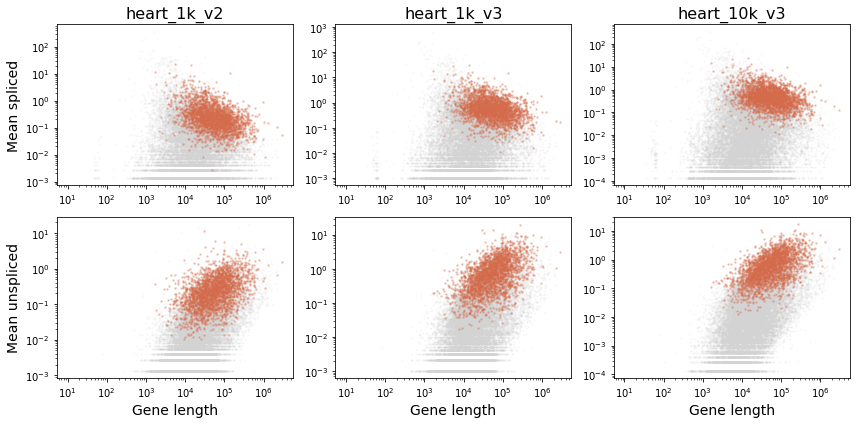

In [909]:
plot_spliced_unspliced_means(dataset_names,transcriptomes,gene_lists,'expression_bias_heart')

#### Neuron

In [910]:
dataset_names = dataset_name_list[2]
loom_filepaths = ['/home/ggorin/count_data/loom_10x_kb/'+x+'.loom' for x in dataset_names]
transcriptomes = [transcriptome_dicts[1]]*3
gene_list_filepaths = ['./fits/'+x+'/genes.csv' for x in [batch_dirs[2]]*3]
gene_lists = [list(pd.read_csv(x,header=None).iloc[0]) for x in gene_list_filepaths]

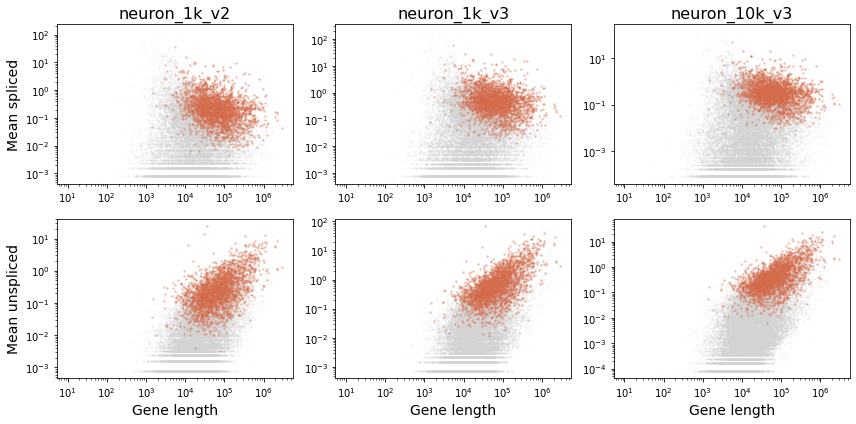

In [911]:
plot_spliced_unspliced_means(dataset_names,transcriptomes,gene_lists,'expression_bias_neuron')

#### Allen

In [912]:
dataset_names = dataset_name_list[3]
loom_filepaths = ['/home/ggorin/count_data/loom_allen_kb/'+x+'_raw.loom' for x in dataset_names]
transcriptomes = [transcriptome_dicts[1]]*7
gene_list_filepaths = ['./fits/'+x+'/genes.csv' for x in [batch_dirs[3]]*7]
gene_lists = [list(pd.read_csv(x,header=None).iloc[0]) for x in gene_list_filepaths]

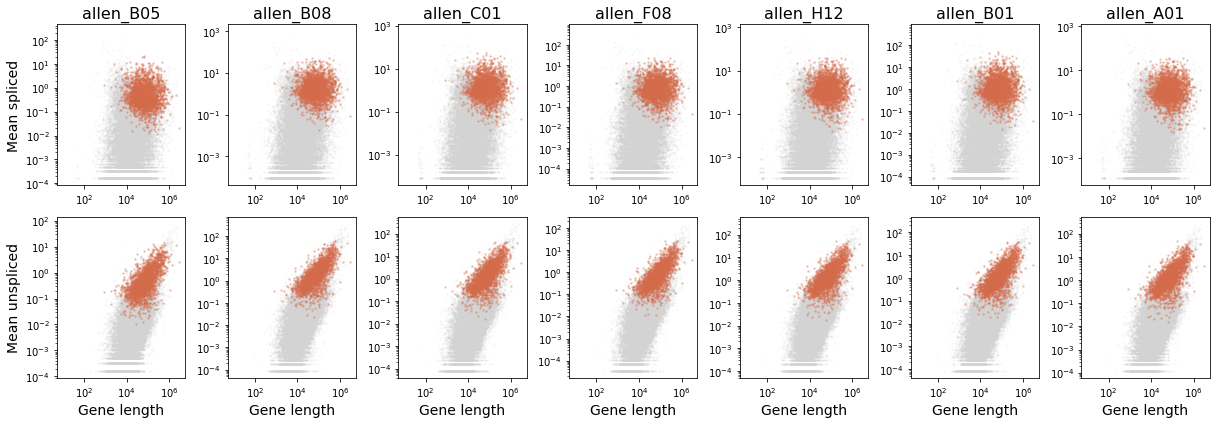

In [913]:
plot_spliced_unspliced_means(dataset_names,transcriptomes,gene_lists,'expression_bias_allen',figsize=(17,6))

### Panel b: Trends under the noise-free model

In [1168]:
def plot_param_length_dependence_noisefree(sr,ax1):
    gene_lengths = 10**sr.gene_log_lengths
    phys_params = 10**sr.phys_optimum

    c = 2.576
    err_high = 10**(sr.phys_optimum + c*sr.sigma) - phys_params
    err_low = phys_params - 10**(sr.phys_optimum - c*sr.sigma)

    gf = ~sr.rejected_genes

    for k in range(3):
        ax1[k].errorbar(gene_lengths[gf],phys_params[gf,k],yerr=[err_low[gf,k],err_high[gf,k]],
                        color=aesthetics['accepted_gene_color'],
                       alpha=aesthetics['accepted_gene_alpha'],linestyle="None",zorder=-100)
        ax1[k].scatter(gene_lengths[~gf],phys_params[~gf,k],
                        color=aesthetics['rejected_gene_color'],
                       alpha=aesthetics['rejected_gene_alpha'],s=aesthetics['rejected_gene_ms'],zorder=100)
        ax1[k].set_ylim([10**sr.sp.phys_lb[k],10**sr.sp.phys_ub[k]])

        ax1[k].set_yscale('log')
        ax1[k].set_xscale('log')


In [1169]:
def plot_and_export_param_length_dependence_noisefree(batch_index,figsize=(12,10)):
    dataset_names = dataset_name_list[batch_index]
    n_datasets = len(dataset_names)
    fig1, ax1 = plt.subplots(nrows=n_datasets,ncols=3,figsize=figsize)
    for k in range(n_datasets):
        dataset_name = dataset_names[k]
        sr = monod.analysis.load_search_results('./fits/'+batch_dirs_noisefree[batch_index]+'/'+dataset_name+'/Bursty_None_1x1/grid_scan_results_upd.res')
        plot_param_length_dependence_noisefree(sr,ax1[k])
    for k in range(n_datasets):
        ax1[k,0].set_ylabel(dataset_names[k],fontsize=aesthetics['fontsize_body_axes'])
    for k in range(n_datasets-1):
        for j in range(3):
            ax1[k,j].set_xticks([])

    for k in range(3):
        ax1[0,k].set_title(param_names[k],fontsize=aesthetics['fontsize_body_axes'])
        ax1[n_datasets-1,k].set_xlabel('Gene length',fontsize=aesthetics['fontsize_body_axes'])

    fig1.tight_layout()
    fig1.savefig('./'+figdir+'/parameter_length_trends_'+batch_names[batch_index]+'.png',dpi=600)

In [1176]:
sr = monod.analysis.load_search_results('./fits/'+batch_dirs_noisefree[0]+'/'+dataset_v3_list[0][1]+'/Bursty_None_1x1/grid_scan_results_upd.res')

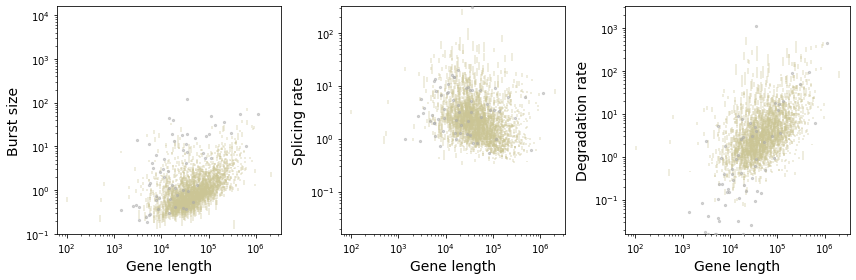

In [1177]:
fig1, ax1 = plt.subplots(nrows=1,ncols=3,figsize=(12,4))
plot_param_length_dependence_noisefree(sr,ax1[:3])
for k in range(3):
    ax1[k].set_ylabel(param_names[k],fontsize=aesthetics['fontsize_body_axes'])
    ax1[k].set_xlabel('Gene length',fontsize=aesthetics['fontsize_body_axes'])
fig1.tight_layout()
fig1.savefig('./'+figdir+'/noisefree_parameter_length_trends_subset.png',dpi=600)

### Supplements to 1b

#### PBMC

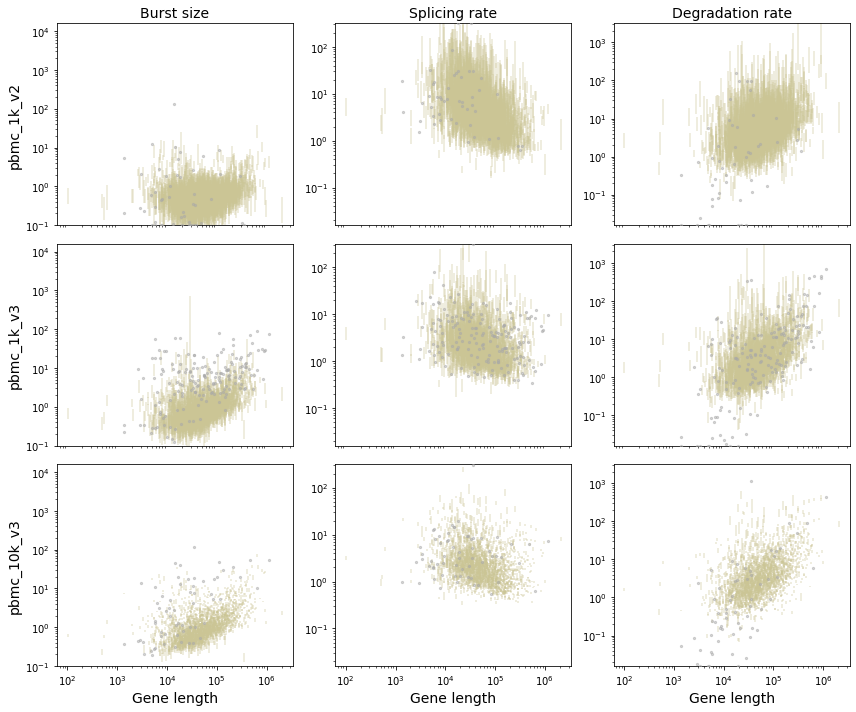

In [1178]:
plot_and_export_param_length_dependence_noisefree(0)

#### Heart

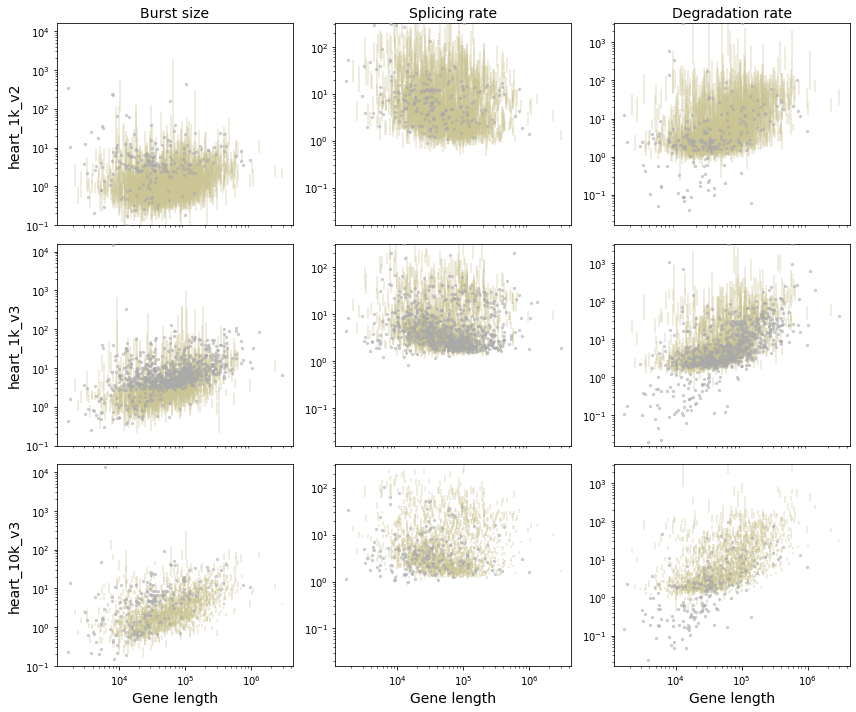

In [1179]:
plot_and_export_param_length_dependence_noisefree(1)

#### Neuron

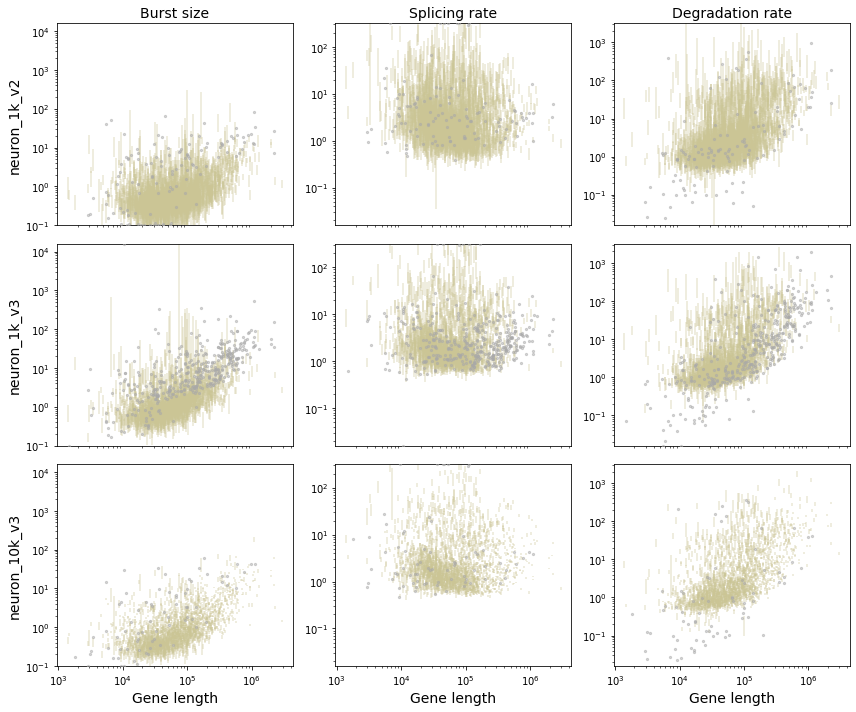

In [1180]:
plot_and_export_param_length_dependence_noisefree(2)

#### Allen

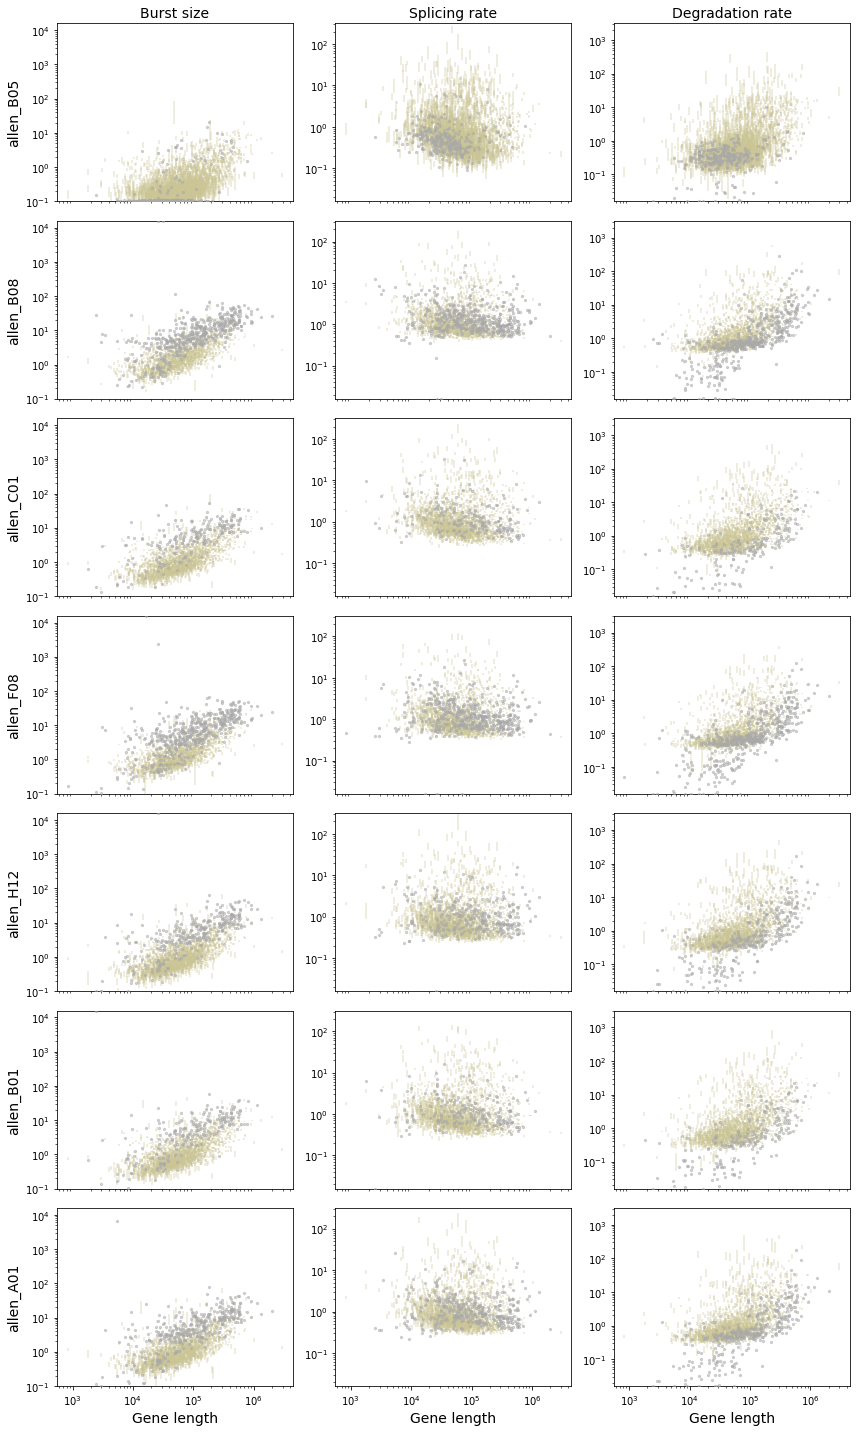

In [1181]:
plot_and_export_param_length_dependence_noisefree(3,figsize=(12,20))

#### v2/v3 comparison

In [1182]:
def plot_params_for_pair_noisefree(sr1,sr2,ax1,omit_rho=False):
    phys_params_1 = 10**sr1.phys_optimum
    phys_params_2 = 10**sr2.phys_optimum

    c = 2.576
    err_high_1 = 10**(sr1.phys_optimum + c*sr1.sigma) - phys_params_1
    err_low_1 = phys_params_1 - 10**(sr1.phys_optimum - c*sr1.sigma)
    err_high_2 = 10**(sr2.phys_optimum + c*sr2.sigma) - phys_params_2
    err_low_2 = phys_params_2 - 10**(sr2.phys_optimum - c*sr2.sigma)

    gf = (~sr1.rejected_genes) & (~sr2.rejected_genes)

    rho = []
    for k in range(3):
        x = phys_params_1[gf,k]
        y = phys_params_2[gf,k]
        ax1[k].errorbar(x,y,
                        xerr=[err_low_1[gf,k],err_high_1[gf,k]],
                        yerr=[err_low_2[gf,k],err_high_2[gf,k]],
                        color=aesthetics['accepted_gene_color'],
                       alpha=aesthetics['accepted_gene_alpha'],linestyle="None",zorder=-100)
        ax1[k].scatter(phys_params_1[~gf,k],phys_params_2[~gf,k],
                        color=aesthetics['rejected_gene_color'],
                       alpha=aesthetics['rejected_gene_alpha'],s=aesthetics['rejected_gene_ms'],zorder=100)
        ax1[k].set_xlim([10**sr1.sp.phys_lb[k],10**sr1.sp.phys_ub[k]])
        ax1[k].set_ylim([10**sr1.sp.phys_lb[k],10**sr1.sp.phys_ub[k]])
        xl = [10**sr1.sp.phys_lb[k],10**sr1.sp.phys_ub[k]]
        ax1[k].plot(xl,xl,'--',color=aesthetics['identity_line_color'],linewidth=aesthetics['identity_lw'],zorder=200)
        ax1[k].set_yscale('log')
        ax1[k].set_xscale('log')

In [1183]:
tech_v2_replicate_pairs

[[0, 2], [0, 2], [0, 2], [0, 5]]

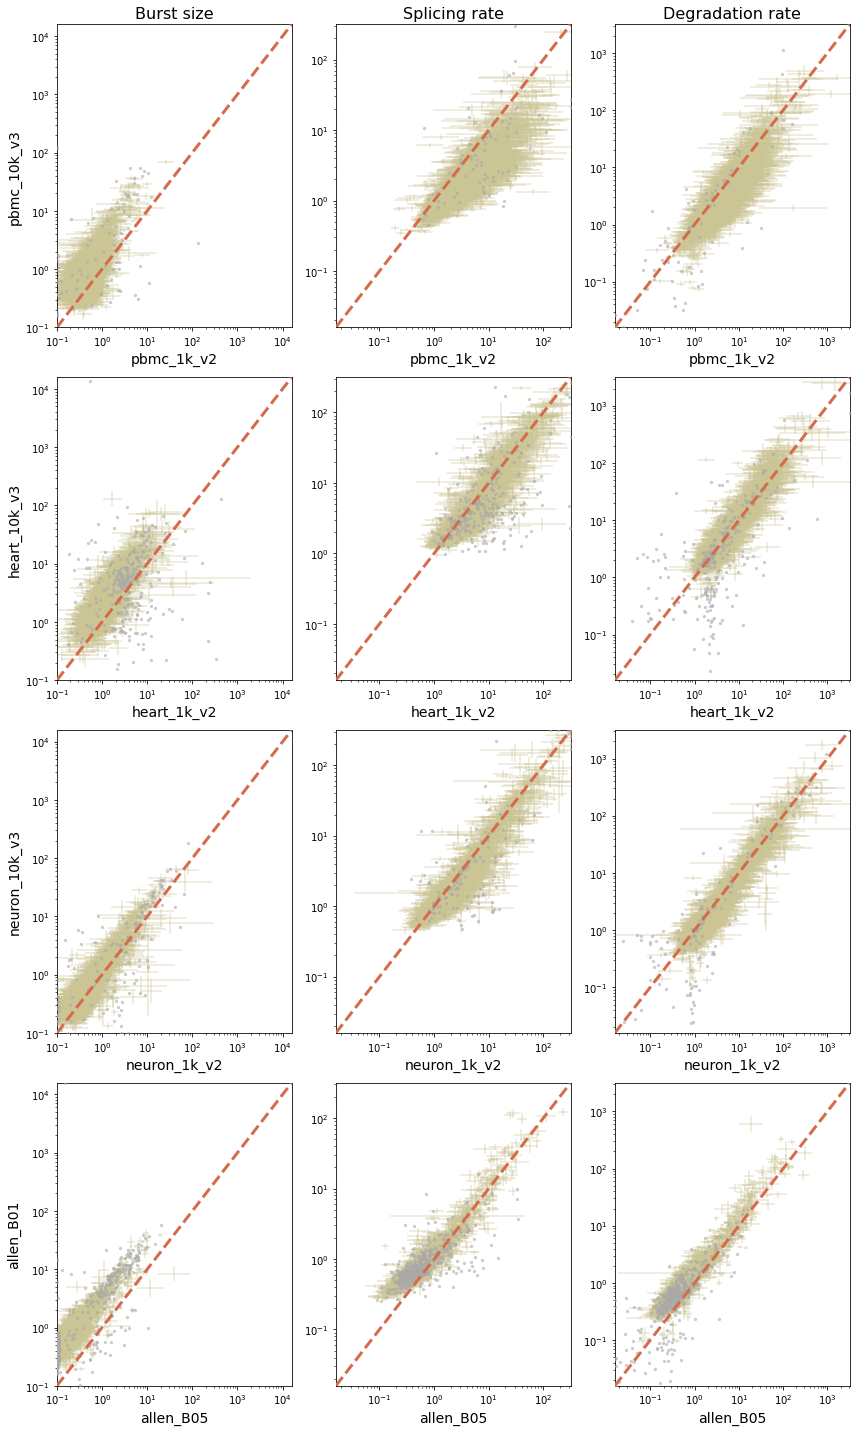

In [1184]:
n_pairs = len(batch_names)
fig1, ax1 = plt.subplots(nrows=n_pairs,ncols=3,figsize=(12,20))
for k in range(3):
    ax1[0,k].set_title(param_names[k],fontsize=aesthetics['fontsize_body_title'])

for batch_index in range(len(batch_names)):
    pair = tech_v2_replicate_pairs[batch_index]
    dataset_1 = dataset_name_list[batch_index][pair[0]]
    dataset_2 = dataset_name_list[batch_index][pair[1]]
    sr1 = monod.analysis.load_search_results('./fits/'+batch_dirs_noisefree[batch_index]+'/'+dataset_1+'/Bursty_None_1x1/grid_scan_results_upd.res')
    sr2 = monod.analysis.load_search_results('./fits/'+batch_dirs_noisefree[batch_index]+'/'+dataset_2+'/Bursty_None_1x1/grid_scan_results_upd.res')
    plot_params_for_pair_noisefree(sr1,sr2,ax1[batch_index])
    ax1[batch_index,0].set_ylabel(dataset_2,fontsize=aesthetics['fontsize_body_axes'])
    for k in range(3):
        ax1[batch_index,k].set_xlabel(dataset_1,fontsize=aesthetics['fontsize_body_axes'])

fig1.tight_layout()
fig1.savefig('./'+figdir+'/v2_noisefree_parameter_comparison.png',dpi=600)


# Fig. 2: the Poisson sampling model

## Panel a: structure of the model 

In [916]:
sd = monod.analysis.load_search_data('./fits/'+batch_dirs[0]+'/'+dataset_v3_list[0][1]+'/raw.sd')

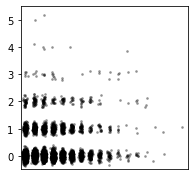

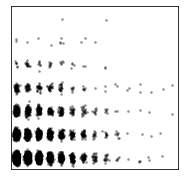

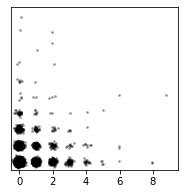

In [918]:
for k in range(3):
    fig1,ax1 = plt.subplots(figsize=(3,3))        
    jitter_magn = 0.1
    jitter = np.random.randn(2, sd.n_cells) * jitter_magn
    ax1.scatter(
        *sd.layers[:2, k] + jitter, c="k", s=3, alpha=0.3
    )

    ax1.set_xlim([-0.5, sd.M[0, k] - 9.5])
    ax1.set_ylim([-0.5, sd.M[1, k] - 9.5])
    
    if k==0:
        ax1.set_xticks([])
    elif k==1:
        ax1.set_xticks([])
        ax1.set_yticks([])
    elif k==2:
        ax1.set_yticks([])
    fig1.savefig(figdir+'/raw_data_'+sd.gene_names[k]+'.png',dpi=600)

## Panel b: parameter values

In [1055]:
def plot_param_length_dependence(sr,ax1):
    gene_lengths = 10**sr.gene_log_lengths
    phys_params = 10**sr.phys_optimum

    c = 2.576
    err_high = 10**(sr.phys_optimum + c*sr.sigma) - phys_params
    err_low = phys_params - 10**(sr.phys_optimum - c*sr.sigma)

    gf = ~sr.rejected_genes

#     fig1, ax1 = plt.subplots(nrows=1,ncols=3,figsize=(12,4))
    for k in range(3):
        ax1[k].errorbar(gene_lengths[gf],phys_params[gf,k],yerr=[err_low[gf,k],err_high[gf,k]],
                        color=aesthetics['accepted_gene_color'],
                       alpha=aesthetics['accepted_gene_alpha'],linestyle="None",zorder=-100)
        ax1[k].scatter(gene_lengths[~gf],phys_params[~gf,k],
                        color=aesthetics['rejected_gene_color'],
                       alpha=aesthetics['rejected_gene_alpha'],s=aesthetics['rejected_gene_ms'],zorder=100)
        ax1[k].set_ylim([10**sr.sp.phys_lb[k],10**sr.sp.phys_ub[k]])

        ax1[k].set_yscale('log')
        ax1[k].set_xscale('log')


In [1127]:
def plot_and_export_param_length_dependence(batch_index,figsize=(12,10)):
    dataset_names = dataset_name_list[batch_index]
    n_datasets = len(dataset_names)
    fig1, ax1 = plt.subplots(nrows=n_datasets,ncols=3,figsize=figsize)
    for k in range(n_datasets):
        dataset_name = dataset_names[k]
        sr = monod.analysis.load_search_results('./fits/'+batch_dirs[batch_index]+'/'+dataset_name+'/Bursty_Poisson_20x21/grid_scan_results_upd.res')
        plot_param_length_dependence(sr,ax1[k])
    for k in range(n_datasets):
        ax1[k,0].set_ylabel(dataset_names[k],fontsize=aesthetics['fontsize_body_axes'])
    for k in range(n_datasets-1):
        for j in range(3):
            ax1[k,j].set_xticks([])

    for k in range(3):
        ax1[0,k].set_title(param_names[k],fontsize=aesthetics['fontsize_body_axes'])
        ax1[n_datasets-1,k].set_xlabel('Gene length',fontsize=aesthetics['fontsize_body_axes'])

    fig1.tight_layout()
    fig1.savefig('./'+figdir+'/parameter_length_trends_'+batch_names[batch_index]+'.png',dpi=600)

In [1108]:
sr = monod.analysis.load_search_results('./fits/'+batch_dirs[0]+'/'+dataset_v3_list[0][1]+'/Bursty_Poisson_20x21/grid_scan_results_upd.res')

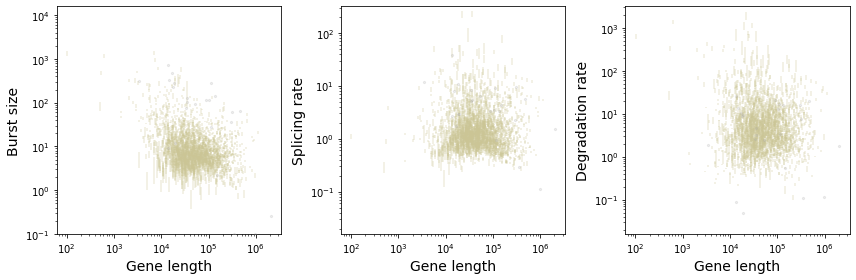

In [1109]:
fig1, ax1 = plt.subplots(nrows=1,ncols=3,figsize=(12,4))
plot_param_length_dependence(sr,ax1[:3])
param_names = ['Burst size','Splicing rate','Degradation rate']
for k in range(3):
    ax1[k].set_ylabel(param_names[k],fontsize=aesthetics['fontsize_body_axes'])
    ax1[k].set_xlabel('Gene length',fontsize=aesthetics['fontsize_body_axes'])
fig1.tight_layout()
fig1.savefig('./'+figdir+'/parameter_length_trends_subset.png',dpi=600)

### Supplements to 2b

#### PBMC

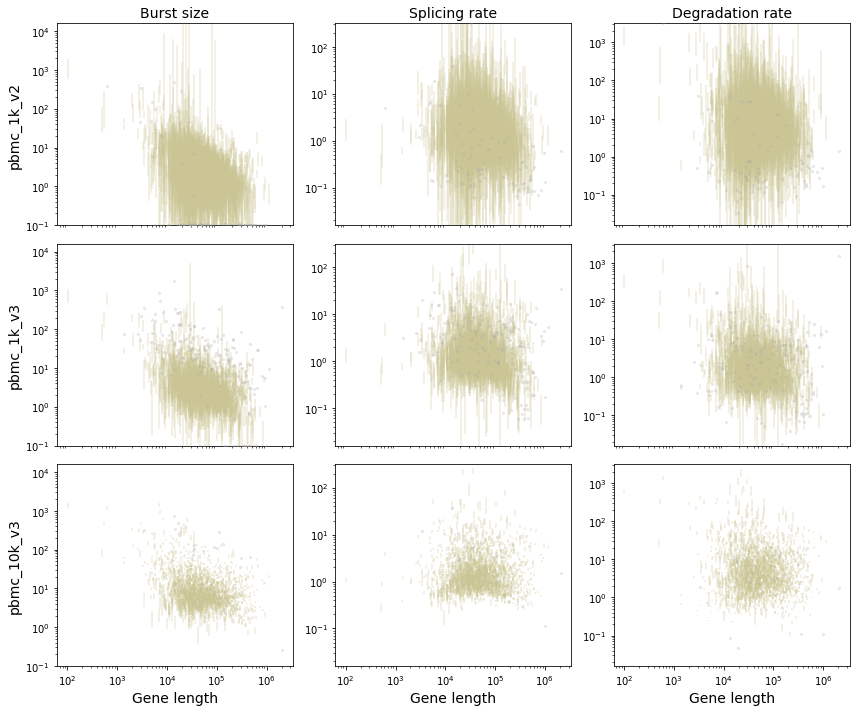

In [1092]:
plot_and_export_param_length_dependence(0)

#### Heart

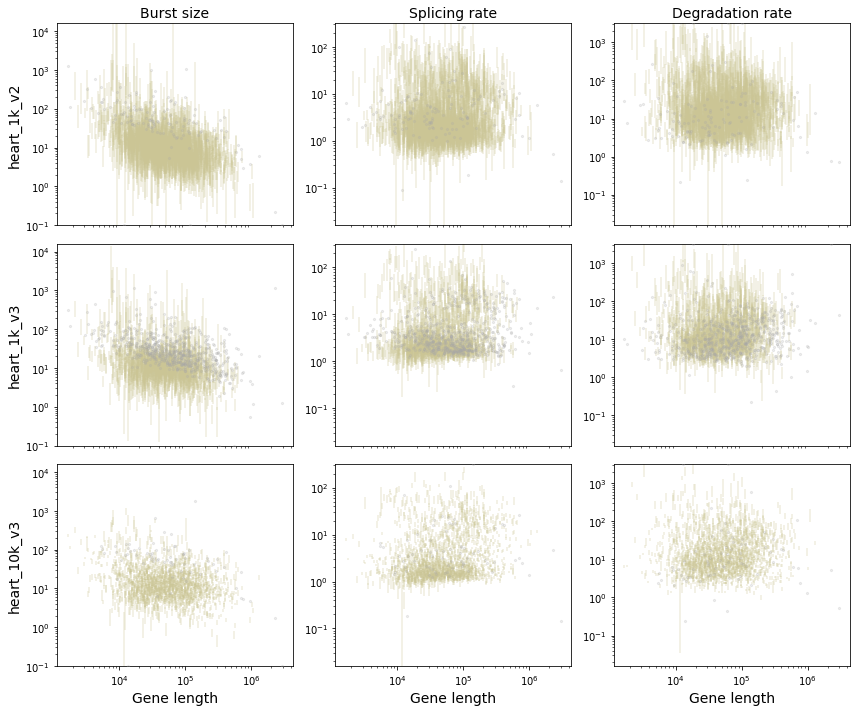

In [1093]:
plot_and_export_param_length_dependence(1)

#### Neuron

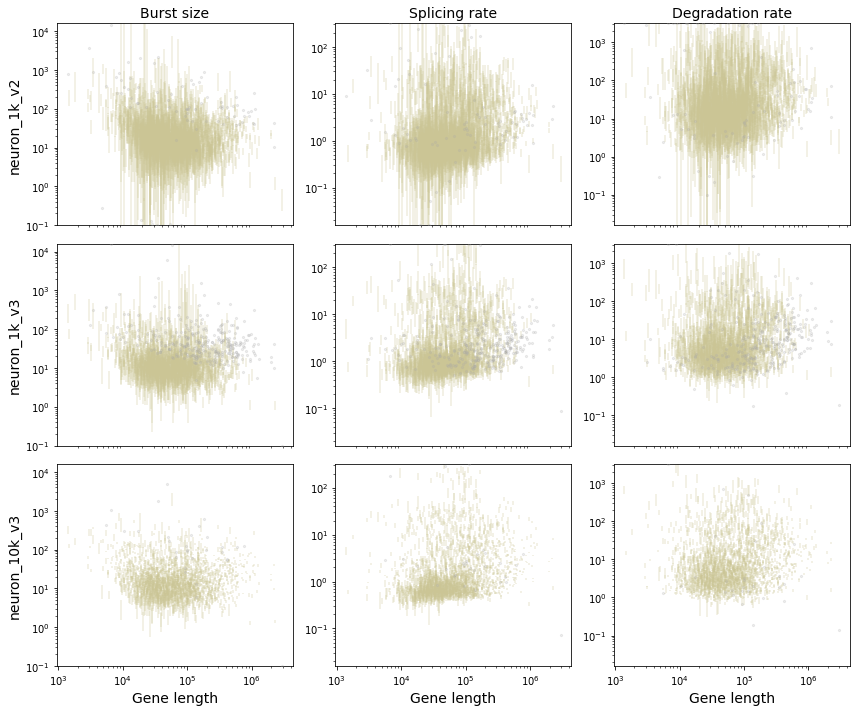

In [1095]:
plot_and_export_param_length_dependence(2)

#### Allen

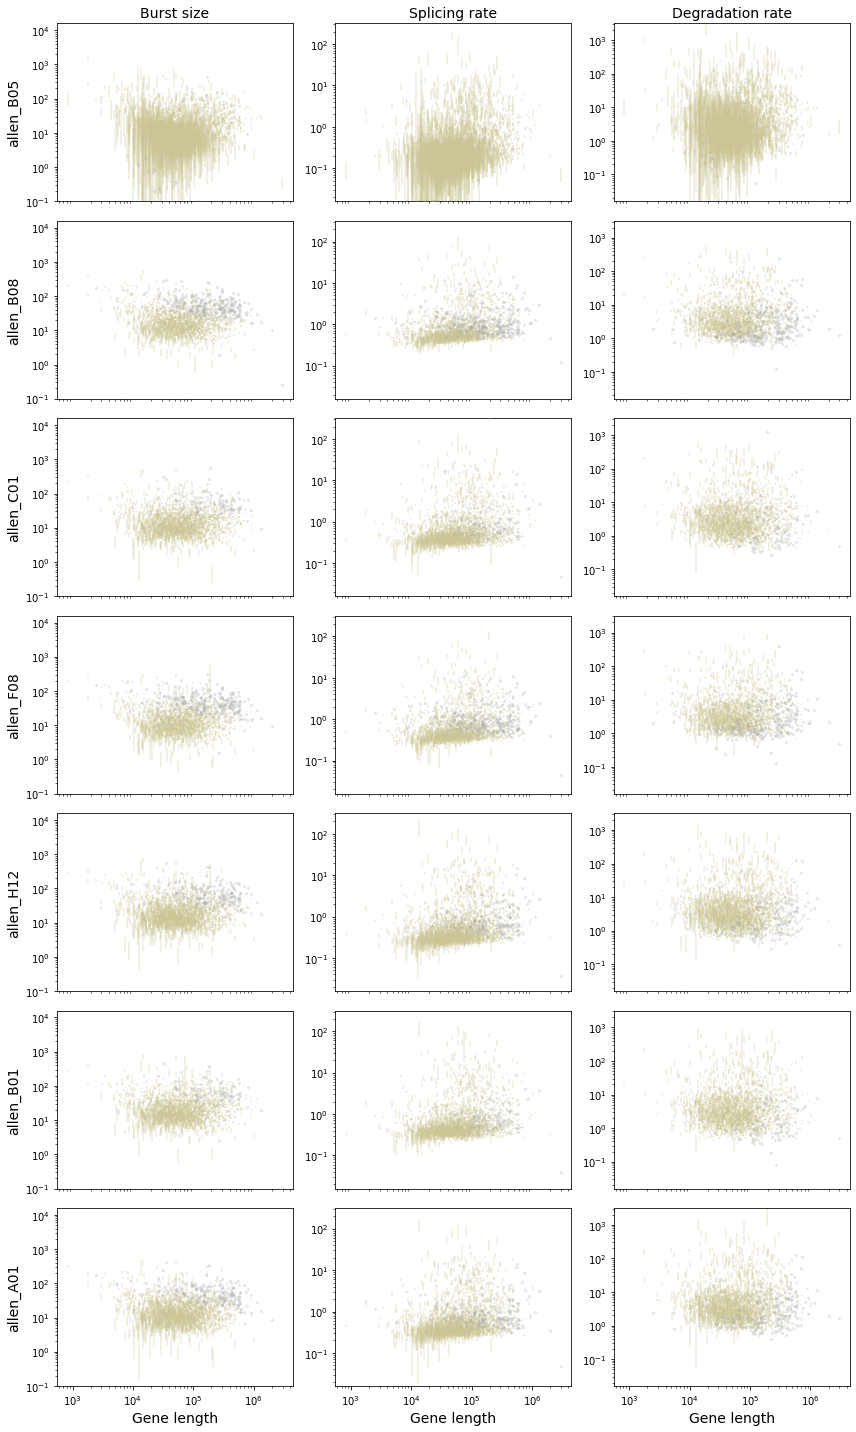

In [1096]:
plot_and_export_param_length_dependence(3,figsize=(12,20))

## Panel c: landscapes

In [1110]:
def plot_landscape(
    sr,
    ax,
    plot_optimum=True,
    gene_filter=None,
):

    total_divergence = sr.obj_func

    total_divergence = np.log10(total_divergence)

    dx = (np.asarray(sr.sp.samp_ub) - np.asarray(sr.sp.samp_lb)) / (
        np.asarray(sr.sp.gridsize) - 1
    )
    dx[dx < 1e-10] = 0.1
    extent = [
        sr.sp.samp_lb[0] - dx[0] / 2,
        sr.sp.samp_ub[0] + dx[0] / 2,
        sr.sp.samp_lb[1] - dx[1] / 2,
        sr.sp.samp_ub[1] + dx[1] / 2,
    ]
    q = np.quantile(total_divergence,0.05)
    lnd = ax.imshow(
        np.flipud(np.reshape(total_divergence, sr.sp.gridsize).T), extent=extent,
        cmap = aesthetics['landscape_colormap']
    )
    lnd = ax.imshow(
        np.flipud(np.reshape(total_divergence>q, sr.sp.gridsize).T), extent=extent,
        cmap = aesthetics['landscape_highlight_colormap'],alpha=0.5
    )

In [1111]:
opt_values = []
opt_colors = []

for j in range(len(batch_dirs)):
    dataset_names = dataset_v3_list[j]
    batch = batch_dirs[j]
    n_datasets = len(dataset_names)
    for k in range(n_datasets):
        dataset_name = dataset_names[k]
        sr = monod.analysis.load_search_results('./fits/'+batch+'/'+dataset_name
                                                +'/Bursty_Poisson_20x21/grid_scan_results_upd.res')
        opt_values.append(sr.samp_optimum)
        opt_colors.append(aesthetics['dataset_colors'][0])

opt_values = np.asarray(opt_values).T
opt_values += np.random.randn(opt_values.shape[0],opt_values.shape[1])/100

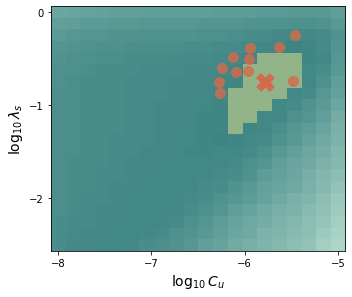

In [1113]:
fig1, ax1 = plt.subplots(figsize=(5,7))
sr = monod.analysis.load_search_results('./fits/'+batch_dirs[0]+'/'+dataset_v3_list[0][1]+'/Bursty_Poisson_20x21/grid_scan_results_upd.res')
plot_landscape(sr,ax1)
ax1.scatter(opt_values[0,:],opt_values[1,:],s=aesthetics['optimum_markersize'],color=aesthetics['optimum_color'],alpha=0.8)
ax1.scatter(opt_values[0,1],opt_values[1,1],s=aesthetics['highlighted_optimum_markersize'],color=aesthetics['optimum_color'],alpha=0.95,
           marker='X')

ax1.set_yticks([-2,-1,0])
ax1.set_xticks([-8,-7,-6,-5])
ax1.set_ylabel(r'$\log_{10} \lambda_s$',fontsize=aesthetics['fontsize_body_axes'])
ax1.set_xlabel(r'$\log_{10} C_u$',fontsize=aesthetics['fontsize_body_axes'])

fig1.tight_layout()
fig1.savefig('./'+figdir+'/landscape_v3.png',dpi=600)


### Supplements to 2c

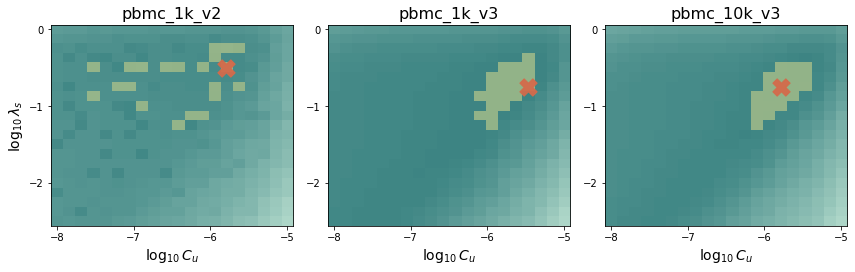

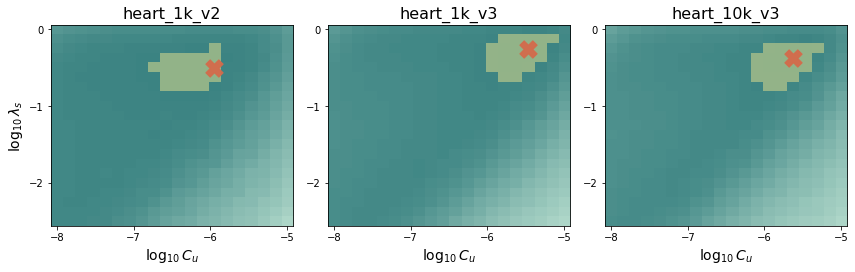

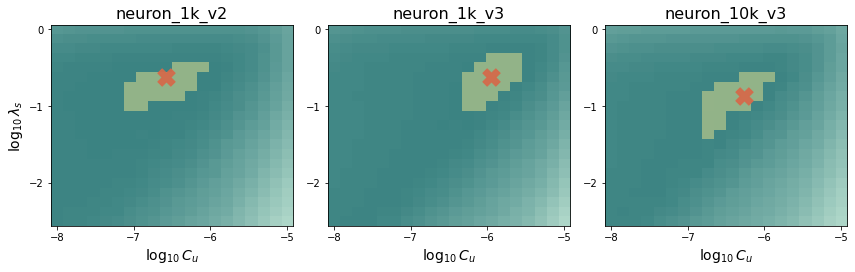

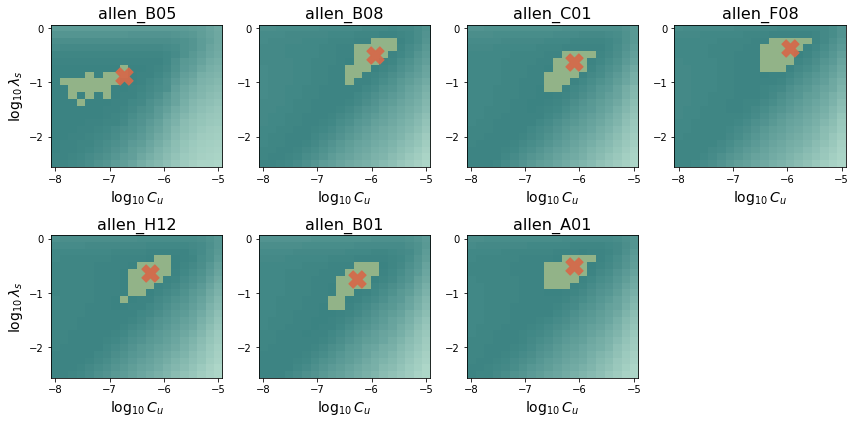

In [1032]:
opt_values = []
opt_colors = []

for j in range(len(batch_dirs)-1):
    dataset_names = dataset_name_list[j]
    fig1, ax1 = plt.subplots(nrows=1,ncols=len(dataset_names),figsize=(12,5))

    batch = batch_dirs[j]
    n_datasets = len(dataset_names)
    for k in range(n_datasets):
        dataset_name = dataset_names[k]
#         if j==0:
#             dataset_name = '10x_'+dataset_name+'_All'
        sr = monod.analysis.load_search_results('./fits/'+batch+'/'+dataset_name
                                                +'/Bursty_Poisson_20x21/grid_scan_results_upd.res')
        plot_landscape(sr,ax1[k])
        ax1[k].scatter(sr.samp_optimum[0],sr.samp_optimum[1],s=aesthetics['highlighted_optimum_markersize'],color=aesthetics['optimum_color'],alpha=0.95,
                   marker='X')
        ax1[k].set_title(dataset_names[k],fontsize=aesthetics['fontsize_body_title'])
        ax1[k].set_xlabel(r'$\log_{10} C_u$',fontsize=aesthetics['fontsize_body_axes'])
        ax1[k].set_yticks([-2,-1,0])
        ax1[k].set_xticks([-8,-7,-6,-5])
    ax1[0].set_ylabel(r'$\log_{10} \lambda_s$',fontsize=aesthetics['fontsize_body_axes'])
    fig1.tight_layout()
    fig1.savefig('./'+figdir+'/landscape_'+batch_names[j]+'.png',dpi=600)

for j in range(len(batch_dirs)-1,len(batch_dirs)):
    dataset_names = dataset_name_list[j]
    fig1, ax1 = plt.subplots(nrows=2,ncols=4,figsize=(12,6))

    batch = batch_dirs[j]
    n_datasets = len(dataset_names)
    for k in range(n_datasets):
        dataset_name = dataset_names[k]
        axloc = np.unravel_index(k,(2,4))
        sr = monod.analysis.load_search_results('./fits/'+batch+'/'+dataset_name
                                                +'/Bursty_Poisson_20x21/grid_scan_results_upd.res')
        plot_landscape(sr,ax1[axloc])
        ax1[axloc].scatter(sr.samp_optimum[0],sr.samp_optimum[1],s=aesthetics['highlighted_optimum_markersize'],color=aesthetics['optimum_color'],alpha=0.95,
                   marker='X')
        ax1[axloc].set_title(dataset_names[k],fontsize=aesthetics['fontsize_body_title'])
#         if k>3:
        ax1[axloc].set_xlabel(r'$\log_{10} C_u$',fontsize=aesthetics['fontsize_body_axes'])
        ax1[axloc].set_yticks([-2,-1,0])
        ax1[axloc].set_xticks([-8,-7,-6,-5])
    ax1[0,0].set_ylabel(r'$\log_{10} \lambda_s$',fontsize=aesthetics['fontsize_body_axes'])
    ax1[1,0].set_ylabel(r'$\log_{10} \lambda_s$',fontsize=aesthetics['fontsize_body_axes'])
    plt.delaxes(ax1[1,3])
    fig1.tight_layout()
    fig1.savefig('./'+figdir+'/landscape_'+batch_names[j]+'.png',dpi=600)


    

## Panel d: distributions

In [1115]:
def plot_gene_distributions(
    sr,
    sd,
    filename,
    sz=(2, 3),
    figsize=(8, 5),
    logscale=True,
    title=True,
    genes_to_plot=None,
):

    (nrows, ncols) = sz
    fig1, ax1 = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

    nax = np.prod(sz)
    if genes_to_plot is None:
        genes_to_plot = np.arange(nax)

    genes_to_plot = np.asarray(genes_to_plot)
    if genes_to_plot.dtype == bool:
        gtp_temp = np.arange(sr.n_genes)
        genes_to_plot = gtp_temp[genes_to_plot]

    number_of_genes_to_plot = len(genes_to_plot)
    if number_of_genes_to_plot > sr.n_genes:
        number_of_genes_to_plot = sr.n_genes
        genes_to_plot = genes_to_plot[: sr.n_genes]
    if number_of_genes_to_plot > nax:  # This should no longer break...
        number_of_genes_to_plot = nax
        genes_to_plot = genes_to_plot[:nax]

    j_ = 0
    for i_ in genes_to_plot:
        lm = np.copy(sd.M[:, i_])
        axloc = np.unravel_index(j_, sz) if (sz[0] > 1 and sz[1] > 1) else j_
        if i_>2:
            ax1[axloc].set_xlabel('Unspliced',fontsize=aesthetics['fontsize_body_axes'])
        if i_%3==0:
            ax1[axloc].set_ylabel('Spliced',fontsize=aesthetics['fontsize_body_axes'])
            
        samp = sr.regressor_optimum[i_]
        Pa = np.squeeze(sr.model.eval_model_pss(sr.phys_optimum[i_], lm, samp))

        if logscale:
            Pa[Pa < 1e-10] = 1e-10
            Pa = np.log10(Pa)

        ax1[axloc].imshow(Pa.T, aspect="auto", cmap=aesthetics['pmf_colormap'])
        ax1[axloc].invert_yaxis()
#         print(sd.M[:,i_])

        jitter_magn = 0.1
        jitter = np.random.randn(2, sr.n_cells) * jitter_magn
        ax1[axloc].scatter(
            *sd.layers[:2, i_] + jitter, c="k", s=1, alpha=0.1
        )

        ax1[axloc].set_xlim([-0.5, sd.M[0, i_] - 5.5])
        ax1[axloc].set_ylim([-0.5, sd.M[1, i_] - 5.5])
        if title:
            titlestr = sr.gene_names[i_]
            if hasattr(sr, "rejected_genes") and sr.rejected_genes[i_]:
                titlestr += " (rej.)"
            ax1[axloc].text(.05,.8,titlestr,transform=ax1[axloc].transAxes,fontsize=25)

        ax1[axloc].set_xticks([])
        ax1[axloc].set_yticks([])
        j_ += 1
    
    fig1.tight_layout(pad=0.02)
    
    fig1.savefig(figdir+'/'+filename+'.png',dpi=600)
    

In [1116]:
sr = monod.analysis.load_search_results('./fits/'+batch_dirs[0]+'/'+dataset_v3_list[0][1]+'/Bursty_Poisson_20x21/grid_scan_results_upd.res')
sd = monod.analysis.load_search_data('./fits/'+batch_dirs[0]+'/'+dataset_v3_list[0][1]+'/raw.sd')

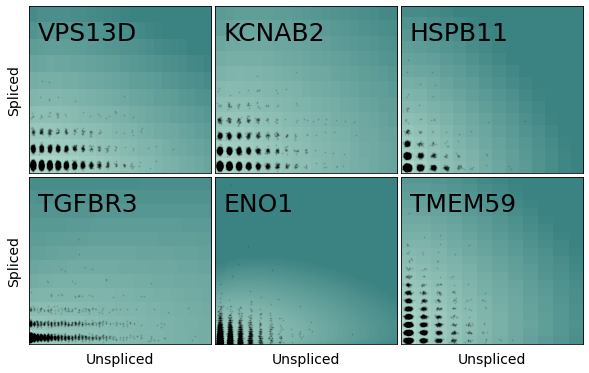

In [1117]:
plot_gene_distributions(sr,sd,'gene_histogram')

# Figure 3: Parameter distributions and distributions reproducibility

## Panel a: parameter distributions

In [1118]:
def plot_param_marg(sr,ax1,nbin=25):
    gf = ~sr.rejected_genes
    phys_params = sr.phys_optimum[gf]
    param_names = ['Burst size','Splicing rate','Degradation rate']
    fitlaw=scipy.stats.norminvgauss
    fitlaws_ = []
    for k in range(3):            
        ax1[k].hist(
                phys_params[:, k],
                nbin,
                density=True,
                color=aesthetics["hist_face_color"],
            )

        ax1[k].set_xlim([sr.sp.phys_lb[k],sr.sp.phys_ub[k]])
        fitparams = fitlaw.fit(phys_params[:, k])

        xmin, xmax = ax1[k].get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = fitlaw.pdf(x, *fitparams)
        ax1[k].plot(
            x,
            p,
            "--",
            linewidth=aesthetics["hist_fit_lw"],
            color=aesthetics["hist_fit_color"],
        )
        fitlaws_.append(fitparams)
    return fitlaws_


In [1119]:
sr = monod.analysis.load_search_results('./fits/'+batch_dirs[0]+'/'+dataset_v3_list[0][1]+'/Bursty_Poisson_20x21/grid_scan_results_upd.res')

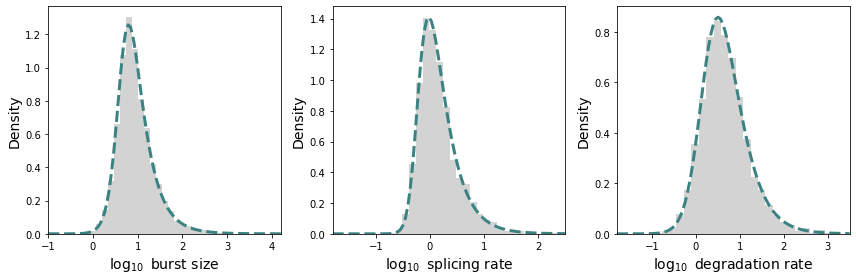

In [1120]:
fig1, ax1 = plt.subplots(nrows=1,ncols=3,figsize=(12,4))
plot_param_marg(sr,ax1[:3])

param_names = ['burst size','splicing rate','degradation rate']

for k in range(3):
    ax1[k].set_xlabel(r'$\log_{10}$ ' + param_names[k],fontsize=aesthetics['fontsize_body_axes'])
    ax1[k].set_ylabel('Density',fontsize=aesthetics['fontsize_body_axes'])
fig1.tight_layout()
fig1.savefig('./'+figdir+'/parameter_distributions_subset.png',dpi=600)

### Supplements to 3a

In [1068]:
fitlaws = []


In [1069]:
def plot_and_export_param_marg(batch_index,figsize=(12,10)):
    dataset_names = dataset_name_list[batch_index]
    n_datasets = len(dataset_names)
    fig1, ax1 = plt.subplots(nrows=n_datasets,ncols=3,figsize=figsize)
    fitlaws_ = []
    for k in range(n_datasets):
        dataset_name = dataset_names[k]
        sr = monod.analysis.load_search_results('./fits/'+batch_dirs[batch_index]+'/'+dataset_name+'/Bursty_Poisson_20x21/grid_scan_results_upd.res')
        fitlaws_.append(plot_param_marg(sr,ax1[k]))
    for k in range(n_datasets):
        ax1[k,0].set_ylabel(dataset_names[k],fontsize=aesthetics['fontsize_body_axes'])
    for k in range(n_datasets-1):
        for j in range(3):
            ax1[k,j].set_xticks([])

    for k in range(3):
        ax1[n_datasets-1,k].set_xlabel(r'$\log_{10}$ ' + param_names[k].lower(),fontsize=aesthetics['fontsize_body_axes'])

    fig1.tight_layout()
    fig1.savefig('./'+figdir+'/parameter_distributions_'+batch_names[batch_index]+'.png',dpi=600)
    return fitlaws_

#### PBMC

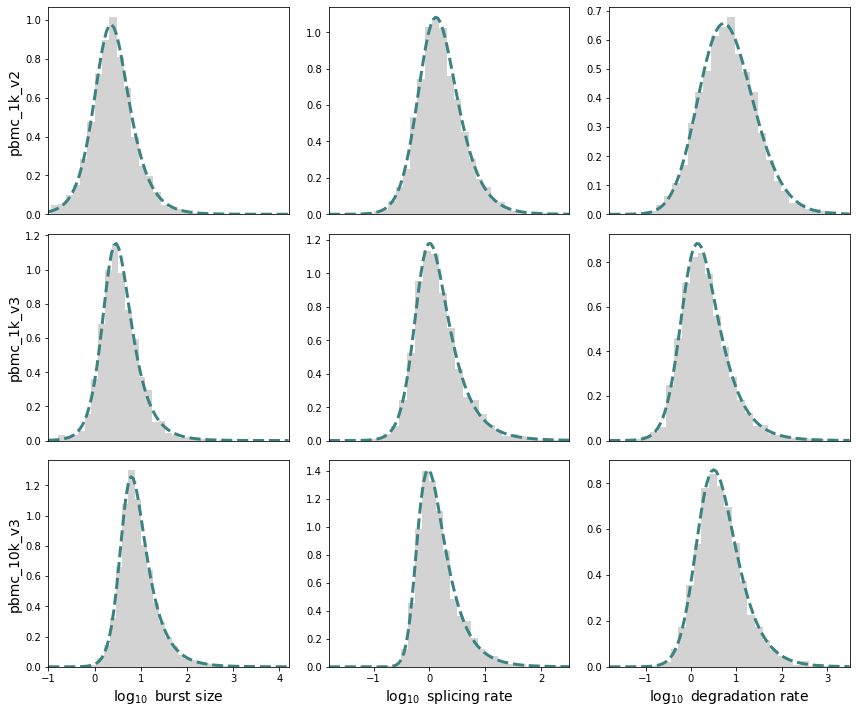

In [1070]:
fitlaws_ = plot_and_export_param_marg(0)
fitlaws.extend(fitlaws_)

#### Heart

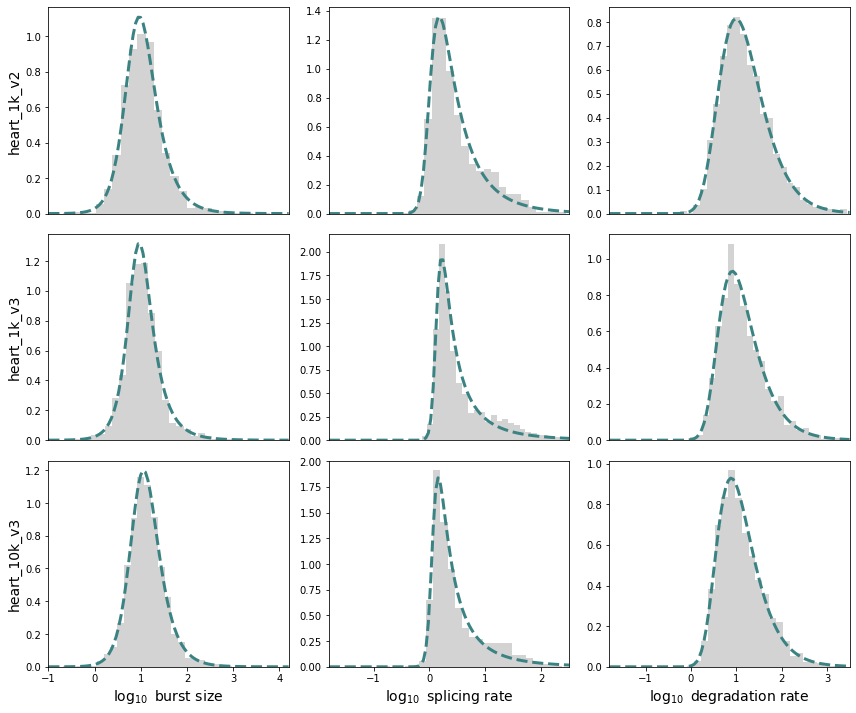

In [1071]:
fitlaws_ = plot_and_export_param_marg(1)
fitlaws.extend(fitlaws_)

#### Neuron

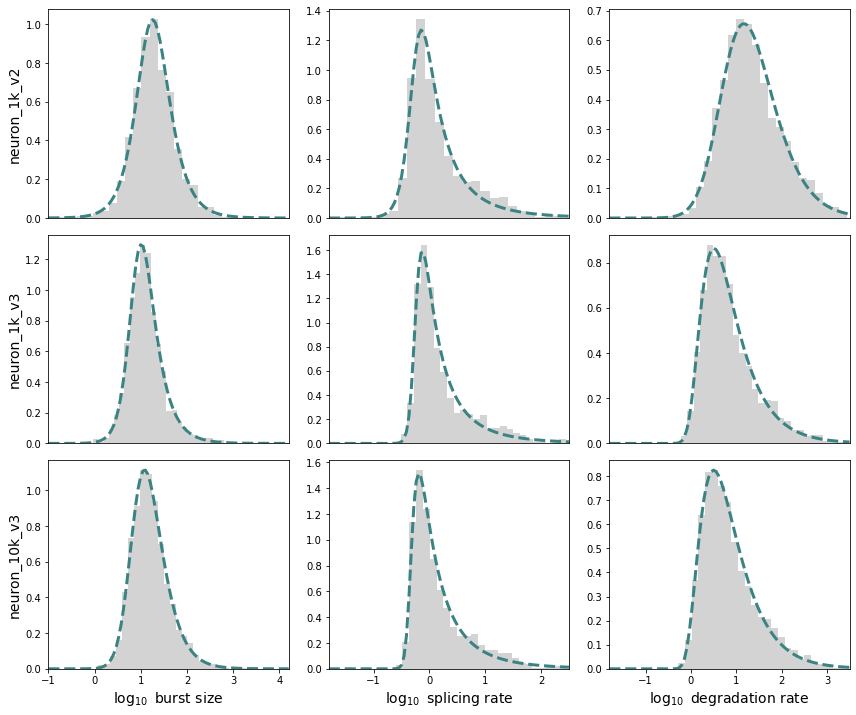

In [1072]:
fitlaws_ = plot_and_export_param_marg(2)
fitlaws.extend(fitlaws_)

#### Allen

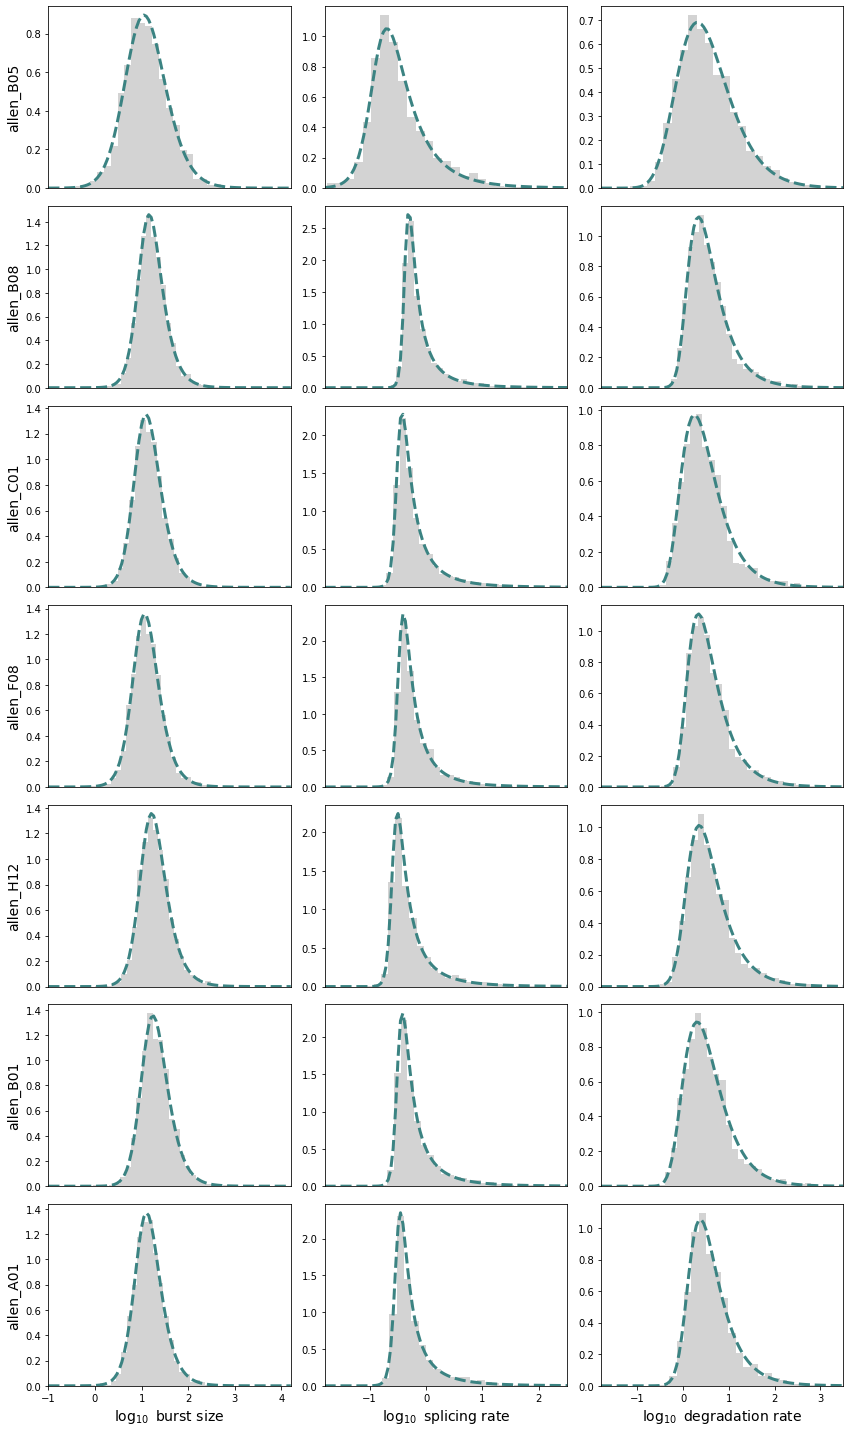

In [1073]:
fitlaws_ = plot_and_export_param_marg(3,figsize=(12,20))
fitlaws.extend(fitlaws_)

#### Aggregated

In [1074]:
fitlaws = np.asarray(fitlaws)

In [1075]:
fitlaws_2 = fitlaws[[1,2,4,5,7,8,10,11,12,13,14,15]]

In [1076]:
aesthetics['dataset_colors']

('violet', 'darkorchid', 'rebeccapurple', 'midnightblue')

In [1077]:
law_colors = [aesthetics['dataset_colors'][0]]*2 + \
             [aesthetics['dataset_colors'][1]]*2 + \
             [aesthetics['dataset_colors'][2]]*2 + \
             [aesthetics['dataset_colors'][3]]*6 

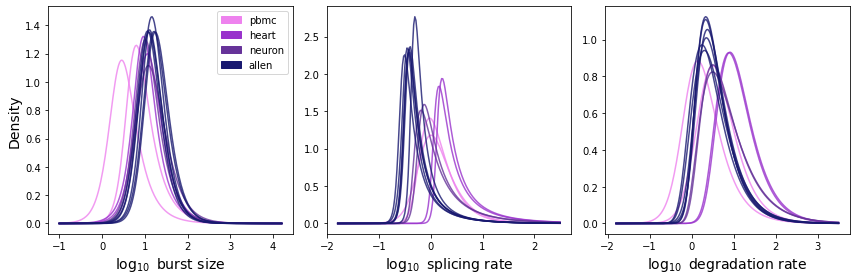

In [1078]:
fig1, ax1 = plt.subplots(nrows=1,ncols=3,figsize=(12,4))
for k in range(3):
    x = np.linspace(sr.sp.phys_lb[k],sr.sp.phys_ub[k],200)
    fitlaw=scipy.stats.norminvgauss
    for j in range(len(fitlaws_2)):
        p = fitlaw.pdf(x, *fitlaws_2[j][k])
        ax1[k].plot(x,p,'-',color=law_colors[j],alpha=0.8)
handles, labels = ax1[0].get_legend_handles_labels()        
for k in range(4):
    legend_patch = mpatches.Patch(color=aesthetics['dataset_colors'][k], label=batch_names[k])
    handles.append(legend_patch)
ax1[0].legend(handles=handles)    

for k in range(3):
    ax1[k].set_xlabel(r'$\log_{10}$ ' + param_names[k].lower(),fontsize=aesthetics['fontsize_body_axes'])
ax1[0].set_ylabel('Density',fontsize=aesthetics['fontsize_body_axes'])
fig1.tight_layout()
fig1.savefig('./'+figdir+'/parameter_distributions_fitlaws_v3.png',dpi=600)


## Panel 3b: biological replicate comparisons

In [1079]:
def plot_params_for_pair(sr1,sr2,ax1,omit_rho=False):
    phys_params_1 = 10**sr1.phys_optimum
    phys_params_2 = 10**sr2.phys_optimum

    c = 2.576
    err_high_1 = 10**(sr1.phys_optimum + c*sr1.sigma) - phys_params_1
    err_low_1 = phys_params_1 - 10**(sr1.phys_optimum - c*sr1.sigma)
    err_high_2 = 10**(sr2.phys_optimum + c*sr2.sigma) - phys_params_2
    err_low_2 = phys_params_2 - 10**(sr2.phys_optimum - c*sr2.sigma)

    gf = (~sr1.rejected_genes) & (~sr2.rejected_genes)

    rho = []
    for k in range(3):
        x = phys_params_1[gf,k]
        y = phys_params_2[gf,k]
        ax1[k].errorbar(x,y,
                        xerr=[err_low_1[gf,k],err_high_1[gf,k]],
                        yerr=[err_low_2[gf,k],err_high_2[gf,k]],
                        color=aesthetics['accepted_gene_color'],
                       alpha=aesthetics['accepted_gene_alpha'],linestyle="None",zorder=-100)
        ax1[k].scatter(phys_params_1[~gf,k],phys_params_2[~gf,k],
                        color=aesthetics['rejected_gene_color'],
                       alpha=aesthetics['rejected_gene_alpha'],s=aesthetics['rejected_gene_ms'],zorder=100)
        ax1[k].set_xlim([10**sr1.sp.phys_lb[k],10**sr1.sp.phys_ub[k]])
        ax1[k].set_ylim([10**sr1.sp.phys_lb[k],10**sr1.sp.phys_ub[k]])
        xl = [10**sr1.sp.phys_lb[k],10**sr1.sp.phys_ub[k]]
        ax1[k].plot(xl,xl,'--',color=aesthetics['identity_line_color'],linewidth=aesthetics['identity_lw'],zorder=200)
        ax1[k].set_yscale('log')
        ax1[k].set_xscale('log')
        rho_ = np.corrcoef(np.log10(x),np.log10(y))[0,1]
        if not omit_rho:
            ax1[k].text(.05,.85,r'$\rho$ = {:.2f}'.format(rho_),fontsize=aesthetics['fontsize_body_title'],transform=ax1[k].transAxes)
        rho.append(rho_)
    return np.asarray(rho)

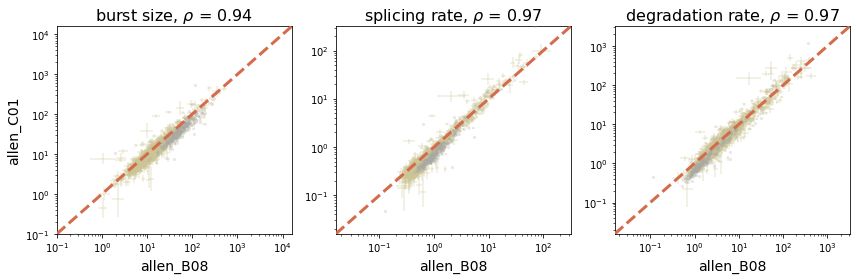

In [1080]:
fig1, ax1 = plt.subplots(nrows=1,ncols=3,figsize=(12,4))
axind = 0

batch_index = 3
pair = [0,1]
dataset_1 = dataset_v3_list[batch_index][pair[0]]
dataset_2 = dataset_v3_list[batch_index][pair[1]]
sr1 = monod.analysis.load_search_results('./fits/'+batch_dirs[batch_index]+'/'+dataset_1+'/Bursty_Poisson_20x21/grid_scan_results_upd.res')
sr2 = monod.analysis.load_search_results('./fits/'+batch_dirs[batch_index]+'/'+dataset_2+'/Bursty_Poisson_20x21/grid_scan_results_upd.res')
rho = plot_params_for_pair(sr1,sr2,ax1,omit_rho=True)
ax1[0].set_ylabel(dataset_2,fontsize=aesthetics['fontsize_body_axes'])
for k in range(3):
    ax1[k].set_xlabel(dataset_1,fontsize=aesthetics['fontsize_body_axes'])
    ax1[k].set_title(param_names[k]+ r', $\rho$ = {:.2f}'.format(rho[k]),fontsize=aesthetics['fontsize_body_title'])

fig1.tight_layout()
fig1.savefig('./'+figdir+'/biological_replicates_subset.png',dpi=600)


### Supplements to 3b

#### Technical replicates

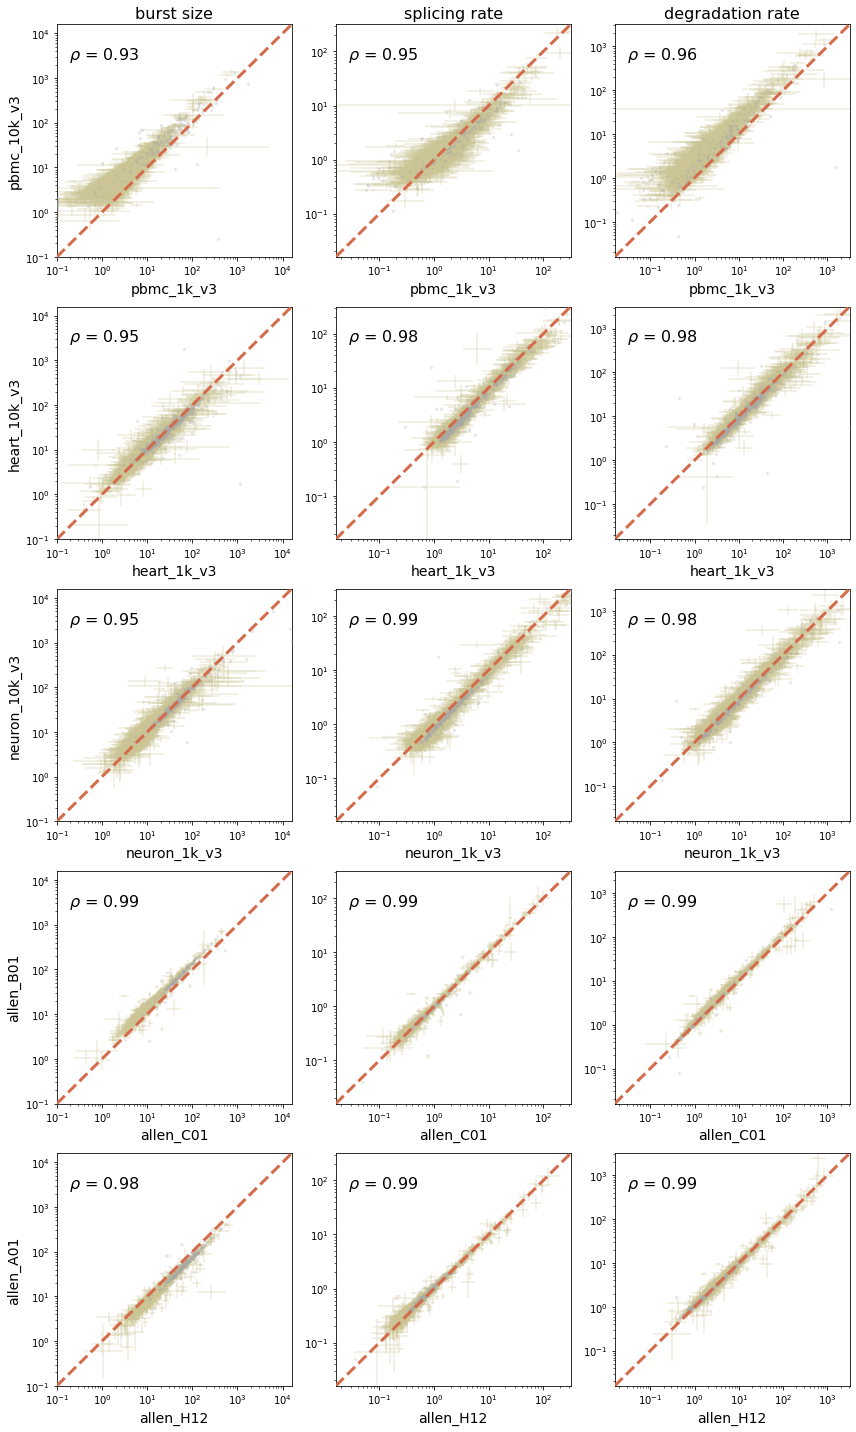

In [1081]:
n_pairs = len(np.concatenate(tech_replicate_pairs))
fig1, ax1 = plt.subplots(nrows=n_pairs,ncols=3,figsize=(12,20))
axind = 0
for k in range(3):
    ax1[0,k].set_title(param_names[k],fontsize=aesthetics['fontsize_body_title'])

for batch_index in range(len(batch_names)):
    for pair in tech_replicate_pairs[batch_index]:
        dataset_1 = dataset_v3_list[batch_index][pair[0]]
        dataset_2 = dataset_v3_list[batch_index][pair[1]]
        sr1 = monod.analysis.load_search_results('./fits/'+batch_dirs[batch_index]+'/'+dataset_1+'/Bursty_Poisson_20x21/grid_scan_results_upd.res')
        sr2 = monod.analysis.load_search_results('./fits/'+batch_dirs[batch_index]+'/'+dataset_2+'/Bursty_Poisson_20x21/grid_scan_results_upd.res')
        plot_params_for_pair(sr1,sr2,ax1[axind])
        ax1[axind,0].set_ylabel(dataset_2,fontsize=aesthetics['fontsize_body_axes'])
        for k in range(3):
            ax1[axind,k].set_xlabel(dataset_1,fontsize=aesthetics['fontsize_body_axes'])
        axind += 1

fig1.tight_layout()
fig1.savefig('./'+figdir+'/technical_replicates.png',dpi=600)


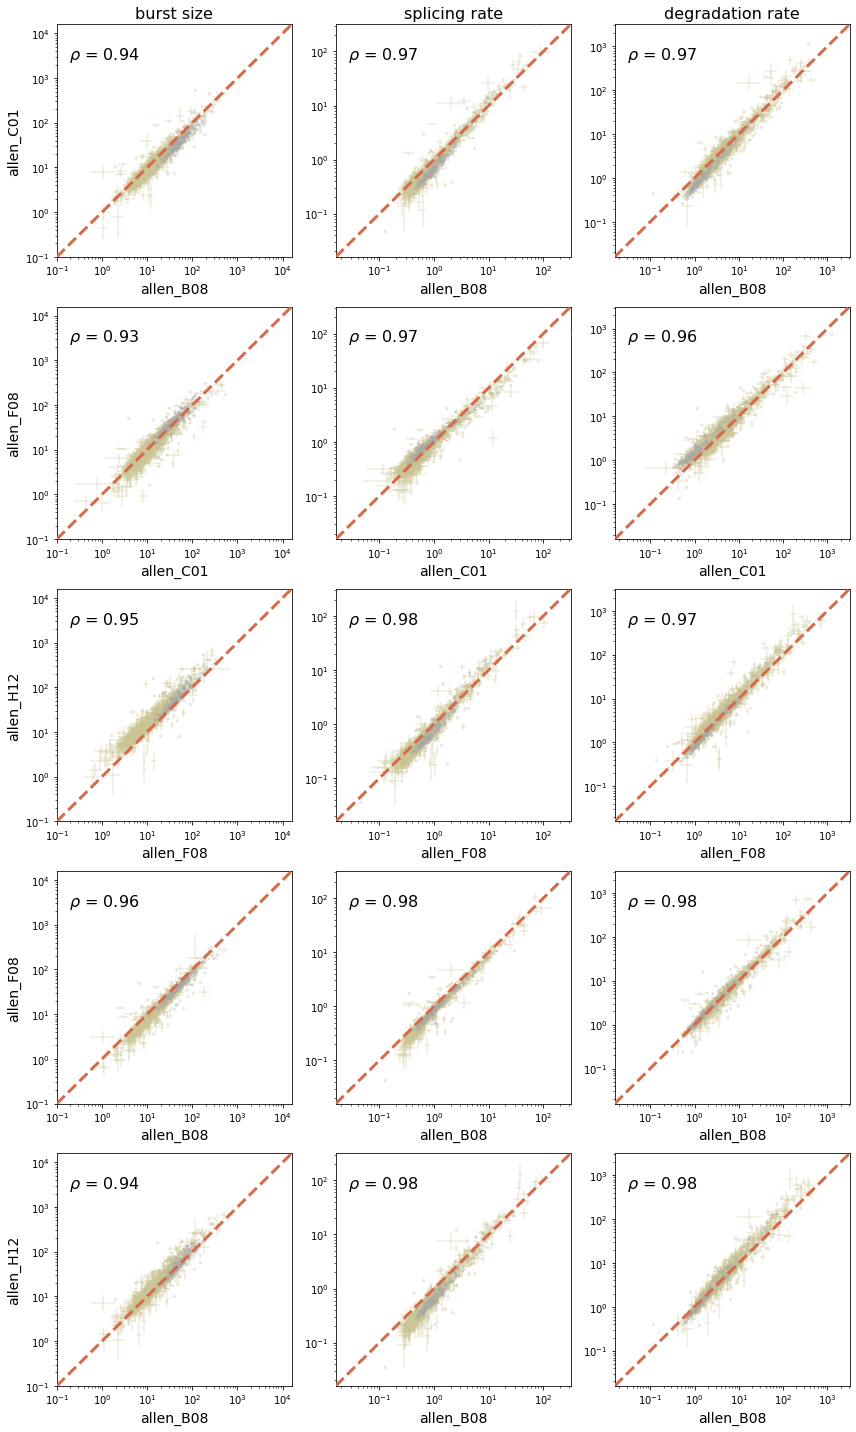

In [1082]:
n_pairs = len(bio_replicate_pairs[-1])
fig1, ax1 = plt.subplots(nrows=n_pairs,ncols=3,figsize=(12,20))
axind = 0
for k in range(3):
    ax1[0,k].set_title(param_names[k],fontsize=aesthetics['fontsize_body_title'])

for batch_index in range(len(batch_names)):
    for pair in bio_replicate_pairs[batch_index]:
        dataset_1 = dataset_v3_list[batch_index][pair[0]]
        dataset_2 = dataset_v3_list[batch_index][pair[1]]
        sr1 = monod.analysis.load_search_results('./fits/'+batch_dirs[batch_index]+'/'+dataset_1+'/Bursty_Poisson_20x21/grid_scan_results_upd.res')
        sr2 = monod.analysis.load_search_results('./fits/'+batch_dirs[batch_index]+'/'+dataset_2+'/Bursty_Poisson_20x21/grid_scan_results_upd.res')
        plot_params_for_pair(sr1,sr2,ax1[axind])
        ax1[axind,0].set_ylabel(dataset_2,fontsize=aesthetics['fontsize_body_axes'])
        for k in range(3):
            ax1[axind,k].set_xlabel(dataset_1,fontsize=aesthetics['fontsize_body_axes'])
        axind += 1

fig1.tight_layout()
fig1.savefig('./'+figdir+'/biological_replicates.png',dpi=600)


## Panels c-d: technical noise lowers the mean and increases variability in v2 samples

In [1083]:
def compare_statistics_v2(X1,X2,ax1,which='mean'):
    pairs = [[1,0],[2,0],[1,2]]

    if which=='mean':
        x = X1.mean(1)
        y = X2.mean(1)
    elif which=='CV2':
        x = X1.var(1)/(X1.mean(1)**2)
        y = X2.var(1)/(X2.mean(1)**2)
    gf = (~np.isnan(x)) & (~np.isnan(y)) & (x>0) & (y>0)
    x = x[gf]
    y = y[gf]
    ax1.scatter(x,y,s=aesthetics['selected_markersize_body'],c=aesthetics['v2_gene_color'],alpha=aesthetics['selected_alpha'])
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    xl = [x.min(),y.max()]
    ax1.plot(xl,xl,'--',color=aesthetics['identity_line_color'],linewidth=aesthetics['identity_lw'],zorder=200)


/tmp/ipykernel_3463100/1344158236.py:8: RuntimeWarning: invalid value encountered in divide
  x = X1.var(1)/(X1.mean(1)**2)
/tmp/ipykernel_3463100/1344158236.py:9: RuntimeWarning: invalid value encountered in divide
  y = X2.var(1)/(X2.mean(1)**2)


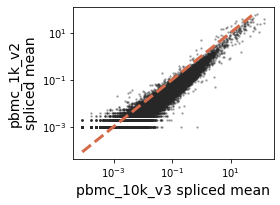

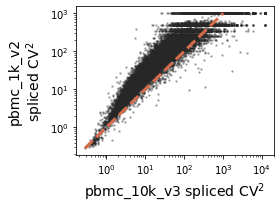

In [1084]:
batch_index = 0
loom_filepaths = [raw_looms[batch_index][tech_v2_replicate_pairs[batch_index][1]],
                  raw_looms[batch_index][tech_v2_replicate_pairs[batch_index][0]]]
datasets = [dataset_name_list[batch_index][tech_v2_replicate_pairs[batch_index][1]],
            dataset_name_list[batch_index][tech_v2_replicate_pairs[batch_index][0]]]
S_arr = []
for file in loom_filepaths:
    with lp.connect(file,mode='r') as ds:
        S_arr.append(ds.layers[spliced_layer][:])

fig1,ax1=plt.subplots(1,1,figsize=(4,3))
compare_statistics_v2(S_arr[0],S_arr[1],ax1)
ax1.set_xlabel(datasets[0]+' spliced mean',fontsize=aesthetics['fontsize_body_axes'])
ax1.set_ylabel(datasets[1]+'\nspliced mean',fontsize=aesthetics['fontsize_body_axes'])
fig1.tight_layout()
fig1.savefig('./'+figdir+'/v2_mean_subset.png',dpi=600)

fig1,ax1=plt.subplots(1,1,figsize=(4,3))
compare_statistics_v2(S_arr[0],S_arr[1],ax1,which='CV2')
ax1.set_xlabel(datasets[0]+' spliced '+r'CV${}^2$',fontsize=aesthetics['fontsize_body_axes'])
ax1.set_ylabel(datasets[1]+'\nspliced '+r'CV${}^2$',fontsize=aesthetics['fontsize_body_axes'])
fig1.tight_layout()
fig1.savefig('./'+figdir+'/v2_cv2_subset.png',dpi=600)

### Supplements to 3c-d

/tmp/ipykernel_3463100/1344158236.py:8: RuntimeWarning: invalid value encountered in divide
  x = X1.var(1)/(X1.mean(1)**2)
/tmp/ipykernel_3463100/1344158236.py:9: RuntimeWarning: invalid value encountered in divide
  y = X2.var(1)/(X2.mean(1)**2)


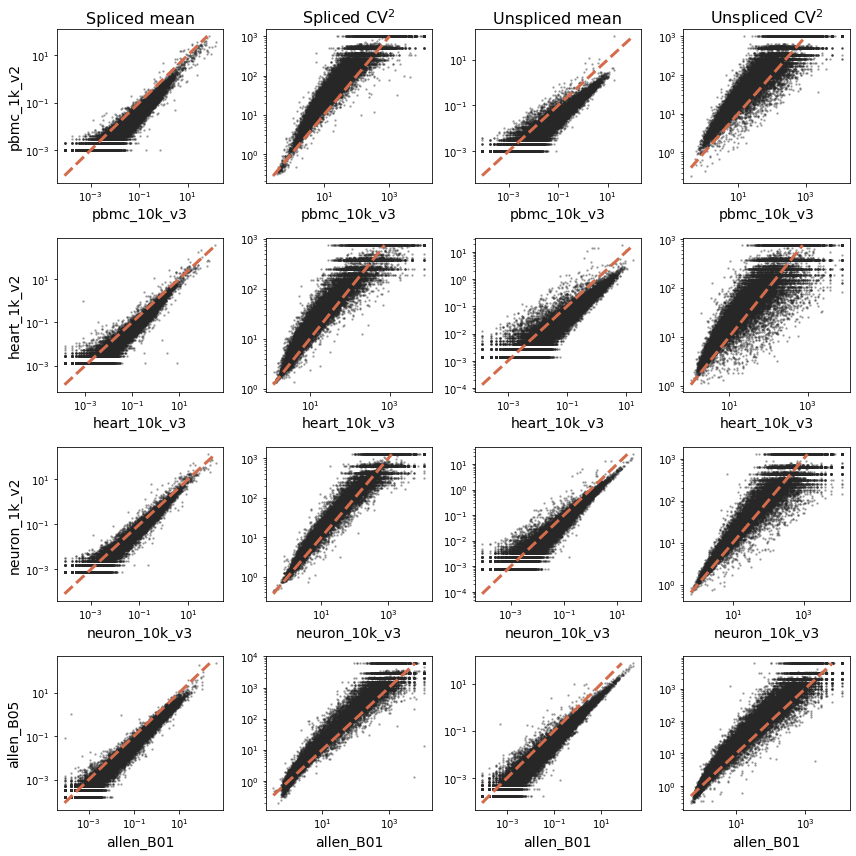

In [1085]:
fig1, ax1 = plt.subplots(nrows=len(batch_names),ncols=4,figsize=(12,12))
for batch_index in range(len(batch_names)):
    loom_filepaths = [raw_looms[batch_index][tech_v2_replicate_pairs[batch_index][1]],
                  raw_looms[batch_index][tech_v2_replicate_pairs[batch_index][0]]]
    datasets = [dataset_name_list[batch_index][tech_v2_replicate_pairs[batch_index][1]],
                dataset_name_list[batch_index][tech_v2_replicate_pairs[batch_index][0]]]
    S_arr = []
    U_arr = []
    for file in loom_filepaths:
        with lp.connect(file,mode='r') as ds:
            S_arr.append(ds.layers[spliced_layer][:])
            U_arr.append(ds.layers[unspliced_layer][:])
    compare_statistics_v2(S_arr[0],S_arr[1],ax1[batch_index,0])
    compare_statistics_v2(S_arr[0],S_arr[1],ax1[batch_index,1],'CV2')
    compare_statistics_v2(U_arr[0],U_arr[1],ax1[batch_index,2])
    compare_statistics_v2(U_arr[0],U_arr[1],ax1[batch_index,3],'CV2')
    
    ax1[batch_index,0].set_ylabel(datasets[1],fontsize=aesthetics['fontsize_body_axes'])
    for k in range(4):
        ax1[batch_index,k].set_xlabel(datasets[0],fontsize=aesthetics['fontsize_body_axes'])
ax1[0,0].set_title('Spliced mean',fontsize=aesthetics['fontsize_body_title'])
ax1[0,1].set_title(r'Spliced CV${}^2$',fontsize=aesthetics['fontsize_body_title'])
ax1[0,2].set_title('Unspliced mean',fontsize=aesthetics['fontsize_body_title'])
ax1[0,3].set_title(r'Unspliced CV${}^2$',fontsize=aesthetics['fontsize_body_title'])
fig1.tight_layout()
fig1.savefig('./'+figdir+'/v2_statistics.png',dpi=600)

## Panel e: technical noise as an explanatory mechanism for biases

In [1086]:
batch_dirs

['gg_221118_025_pbmc_1',
 'gg_221115_025_heart_1',
 'gg_221116_025_neuron_1',
 'gg_221118_025_allen_1']

In [1087]:
opt_values_v3 = []
opt_values_v2 = []
opt_colors = []


for j in range(len(batch_dirs)):
    dataset_names = dataset_v3_list[j]
    batch = batch_dirs[j]
    n_datasets = len(dataset_names)
    for k in range(n_datasets):
        dataset_name = dataset_names[k]
        sr = monod.analysis.load_search_results('./fits/'+batch+'/'+dataset_name
                                                +'/Bursty_Poisson_20x21/grid_scan_results_upd.res')
        opt_values_v3.append(sr.samp_optimum)
        opt_colors.append(aesthetics['dataset_colors'][j])
    sr_v2 = monod.analysis.load_search_results('./fits/'+batch+'/'+dataset_v2_list[j]
                                    +'/Bursty_Poisson_20x21/grid_scan_results_upd.res')
    sr_v2.set_sampling_optimum(
        np.argmin(((sr_v2.param_estimates[:,~sr.rejected_genes,:] - sr.phys_optimum[~sr.rejected_genes])**2).sum((1,2))))
    opt_values_v2.append(sr_v2.samp_optimum)
opt_values_v3 = np.asarray(opt_values_v3).T
opt_values_v2 = np.asarray(opt_values_v2).T
opt_values_v3 += np.random.randn(opt_values_v3.shape[0],opt_values_v3.shape[1])/100

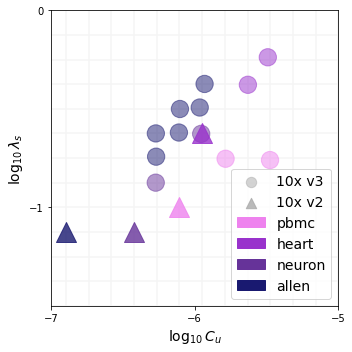

In [1088]:
fig1, ax1 = plt.subplots(figsize=(5,5))
# sr = monod.analysis.load_search_results('./fits/gg_221111_025_pbmc_celltypes_5/10x_pbmc_1k_v3_All/Bursty_Poisson_20x21/grid_scan_results_upd.res')
# plot_landscape(sr,ax1)

xl = [sr.sp.samp_lb[0],sr.sp.samp_ub[0]]
yl = [sr.sp.samp_lb[1],sr.sp.samp_ub[1]]
x=np.linspace(xl[0],xl[1],sr.sp.gridsize[0])
y=np.linspace(yl[0],yl[1],sr.sp.gridsize[1])
for i in range(sr.sp.gridsize[0]):
    plt.plot([x[i]]*2,yl,c='whitesmoke',zorder=-100)
for i in range(sr.sp.gridsize[1]):
    plt.plot(xl,[y[i]]*2,c='whitesmoke',zorder=-100)

ax1.scatter(opt_values_v3[0],opt_values_v3[1],s=300,color=opt_colors,alpha=0.5)
for k in range(4):
    ax1.scatter(opt_values_v2[0][k],opt_values_v2[1][k],s=400,
                color=aesthetics['dataset_colors'][k],alpha=0.8,marker='^')


# for legend
ax1.scatter(0,0,300,'darkgray',alpha=0.5,label='10x v3')    
ax1.scatter(0,0,300,'darkgray',alpha=0.8,marker='^',label='10x v2')
handles, labels = ax1.get_legend_handles_labels()
for k in range(4):
    legend_patch = mpatches.Patch(color=aesthetics['dataset_colors'][k], label=batch_names[k])
    handles.append(legend_patch)
ax1.set_yticks([-1,0])
ax1.set_ylim([-1.5,0])
ax1.set_xticks([-7,-6,-5])
ax1.set_xlim([-7,-5])
ax1.set_ylabel(r'$\log_{10} \lambda_s$',fontsize=aesthetics['fontsize_body_axes'])
ax1.set_xlabel(r'$\log_{10} C_u$',fontsize=aesthetics['fontsize_body_axes'])


ax1.legend(handles=handles,loc='lower right',markerscale=0.6,fontsize=aesthetics['fontsize_body_axes'])
fig1.tight_layout()
fig1.savefig('./'+figdir+'/landscape_v2.png',dpi=600)


### Supplements to 3e

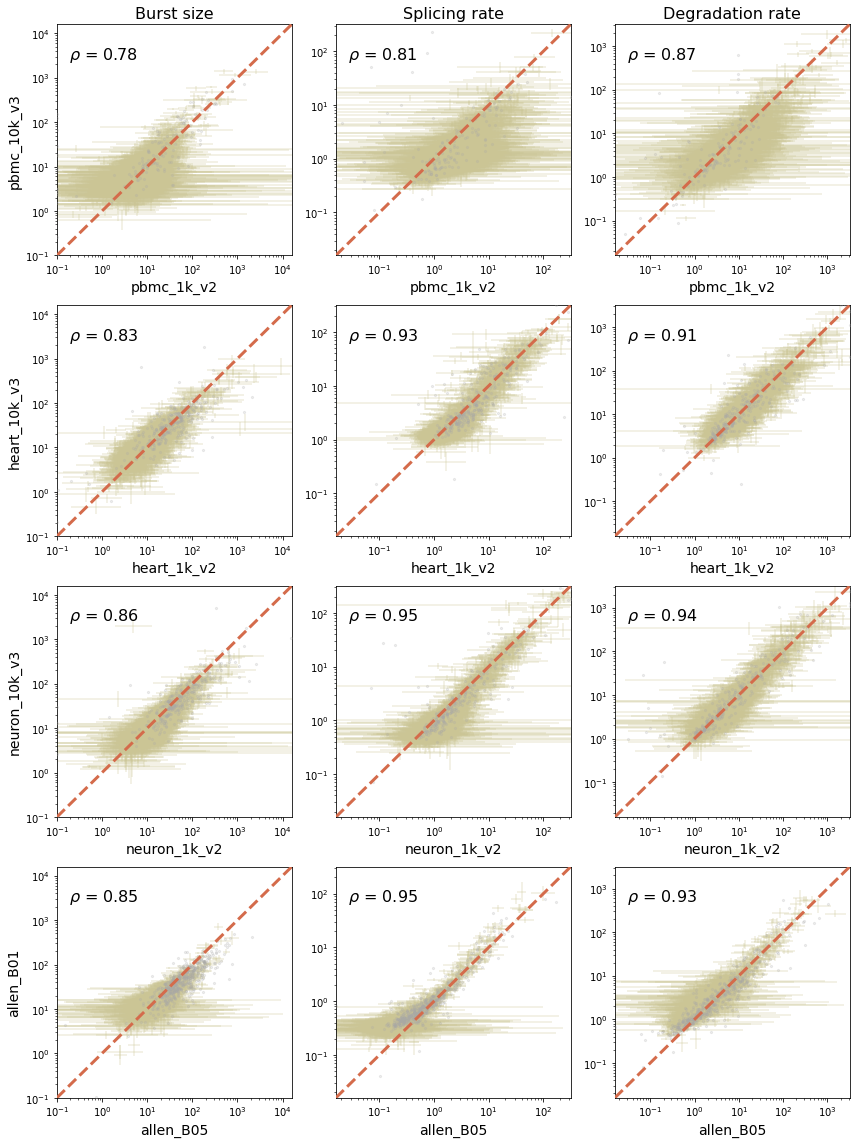

In [1158]:
n_pairs = len(batch_names)
fig1, ax1 = plt.subplots(nrows=n_pairs,ncols=3,figsize=(12,16))
for k in range(3):
    ax1[0,k].set_title(param_names[k],fontsize=aesthetics['fontsize_body_title'])

for batch_index in range(len(batch_names)):
    pair = tech_v2_replicate_pairs[batch_index]
    dataset_1 = dataset_name_list[batch_index][pair[0]]
    dataset_2 = dataset_name_list[batch_index][pair[1]]
    sr1 = monod.analysis.load_search_results('./fits/'+batch_dirs[batch_index]+'/'+dataset_1+'/Bursty_Poisson_20x21/grid_scan_results_upd.res')
    sd1 = monod.analysis.load_search_data('./fits/'+batch_dirs[batch_index]+'/'+dataset_1+'/raw.sd')
    sr2 = monod.analysis.load_search_results('./fits/'+batch_dirs[batch_index]+'/'+dataset_2+'/Bursty_Poisson_20x21/grid_scan_results_upd.res')
    sr1.set_sampling_optimum(
        np.argmin(((sr1.param_estimates[:,~sr2.rejected_genes,:] - sr2.phys_optimum[~sr2.rejected_genes])**2).sum((1,2))))
    sr1.chisquare_testing(sd1,threshold=0.01)
    plot_params_for_pair(sr1,sr2,ax1[batch_index])
    ax1[batch_index,0].set_ylabel(dataset_2,fontsize=aesthetics['fontsize_body_axes'])
    for k in range(3):
        ax1[batch_index,k].set_xlabel(dataset_1,fontsize=aesthetics['fontsize_body_axes'])

fig1.tight_layout()
fig1.savefig('./'+figdir+'/v2_parameter_correction.png',dpi=600)

# Figure 4: parameter modulation within datasets

## Panel a: comparison of parameter values between cell types

In [1228]:
sr_arr_pbmc = [monod.analysis.load_search_results('./fits/'+pbmc_celltype_batch_dir+'/'+x+'/Bursty_Poisson_20x21/grid_scan_results_upd.res') for x in pbmc_celltypes]
sd_arr_pbmc = [monod.analysis.load_search_data('./fits/'+pbmc_celltype_batch_dir+'/'+x+'/raw.sd') for x in pbmc_celltypes]
sr_pbmc_baseline = monod.analysis.load_search_results('./fits/'+pbmc_baseline_dir+'/'+pbmc_celltype_dataset+'/Bursty_Poisson_20x21/grid_scan_results_upd.res')

In [1229]:
pbmc_celltypes

['pbmc_10k_v3_Tcells', 'pbmc_10k_v3_Monocytes', 'pbmc_10k_v3_Bcells']

In [1230]:
sr_pbmc_baseline.samp_optimum

(-5.7894736842105265, -0.75)

In [1231]:
[x.samp_optimum for x in sr_arr_pbmc]

[(-5.631578947368421, -0.75),
 (-5.7894736842105265, -1.0),
 (-5.631578947368421, -0.875)]

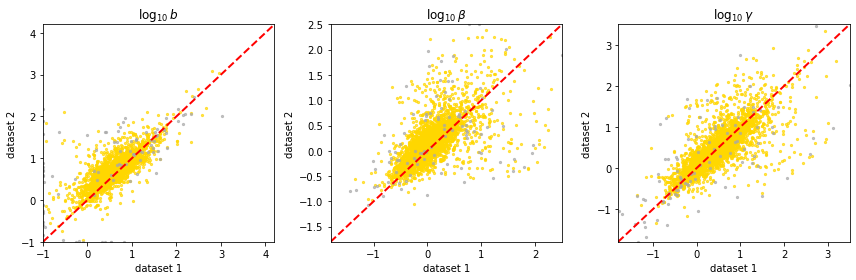

In [1232]:
monod.analysis.plot_params_for_pair(sr_arr_pbmc[0],sr_arr_pbmc[2])

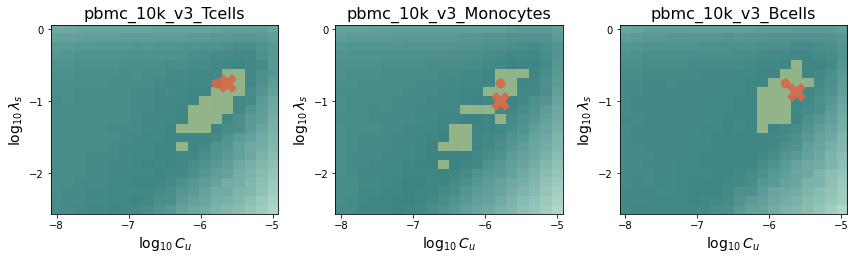

In [1233]:
fig1, ax1 = plt.subplots(nrows=1,ncols=3,figsize=(12,4))

for k in range(3):
    plot_landscape(sr_arr_pbmc[k],ax1[k])
    ax1[k].scatter(sr_arr_pbmc[k].samp_optimum[0],sr_arr_pbmc[k].samp_optimum[1],s=aesthetics['highlighted_optimum_markersize'],color=aesthetics['optimum_color'],alpha=0.95,
               marker='X')
    ax1[k].scatter(sr_pbmc_baseline.samp_optimum[0],sr_baseline.samp_optimum[1],
                   s=aesthetics['highlighted_optimum_markersize'],color=aesthetics['optimum_color'],alpha=0.95,
                   marker = '.')
    ax1[k].set_title(pbmc_celltypes[k],fontsize=aesthetics['fontsize_body_title'])
    ax1[k].set_ylabel(r'$\log_{10} \lambda_s$',fontsize=aesthetics['fontsize_body_axes'])
    ax1[k].set_xlabel(r'$\log_{10} C_u$',fontsize=aesthetics['fontsize_body_axes'])
    ax1[k].set_yticks([-2,-1,0])
    ax1[k].set_xticks([-8,-7,-6,-5])
fig1.tight_layout()
fig1.savefig('./'+figdir+'/landscape_celltypes_pbmc.png',dpi=600)

In [1234]:
for k in range(3):
    sr_arr_pbmc[k].set_sampling_optimum(sr_pbmc_baseline.samp_optimum_ind)
    _=sr_arr_pbmc[k].chisquare_testing(sd_arr_pbmc[k],threshold=0.01)

In [1235]:
def plot_marker_gene_pairs(sr_arr,pair,markers,celltype_names,ax1):
    gn = sr_arr[0].gene_names
    n_genes = len(gn)

    gf_rej = (~sr_arr[pair[1]].rejected_genes) & (~sr_arr[pair[0]].rejected_genes)
    fc_par = (sr_arr[pair[1]].phys_optimum-sr_arr[pair[0]].phys_optimum)/np.log10(2)

    gf_mark_ = [np.where(gn == x)[0][0] for x in markers[pair[0]]]
    gf_mark_pop_0 = np.zeros(n_genes,dtype=bool)
    gf_mark_pop_0[gf_mark_] = True


    gf_mark_ = [np.where(gn == x)[0][0] for x in markers[pair[1]]]
    gf_mark_pop_1 = np.zeros(n_genes,dtype=bool)
    gf_mark_pop_1[gf_mark_] = True
    
    
    for k in range(3):
        x = 10**sr_arr[pair[0]].phys_optimum[:,k]
        y = 10**sr_arr[pair[1]].phys_optimum[:,k]
        ax1[k].scatter(x[gf_rej],y[gf_rej],
                       s=aesthetics['celltype_diffs_ms'],
                       c=aesthetics['celltype_diffs_gene_color'],
                       alpha=aesthetics['celltype_diffs_gene_alpha'])
        ax1[k].scatter(x[gf_mark_pop_0],y[gf_mark_pop_0],
                       s=aesthetics['celltype_marker_ms'],
                       c=aesthetics['celltype_colors'][pair[0]],
                       alpha=aesthetics['celltype_marker_alpha'])
        ax1[k].scatter(x[gf_mark_pop_1],y[gf_mark_pop_1],
                       s=aesthetics['celltype_marker_ms'],
                       c=aesthetics['celltype_colors'][pair[1]],
                       alpha=aesthetics['celltype_marker_alpha'])
        ax1[k].set_xlabel(param_names[k]+' in '+celltype_names[pair[0]],fontsize=aesthetics['fontsize_body_axes'])
        ax1[k].set_ylabel(param_names[k]+' in '+celltype_names[pair[1]],fontsize=aesthetics['fontsize_body_axes'])
        xl = [x.min(),y.max()]        
        ax1[k].plot(xl,xl,'--',color=aesthetics['identity_line_color'],linewidth=aesthetics['identity_lw'],zorder=200)
        ax1[k].set_xscale('log')
        ax1[k].set_yscale('log')

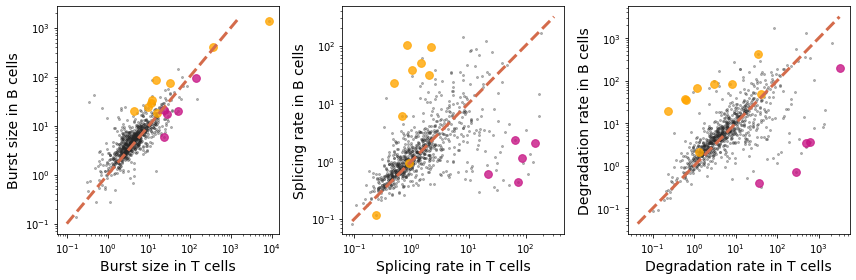

In [1237]:
pbmc_pairs = [[0,1],[0,2],[1,2]]
pair = pbmc_pairs[1]
fig1,ax1 = plt.subplots(1,3,figsize=(12,4))
plot_marker_gene_pairs(sr_arr_pbmc,pair,pbmc_markers,pbmc_celltype_names_labels,ax1)
fig1.tight_layout()
fig1.savefig('./'+figdir+'/celltype_diffs_pbmc_subset.png',dpi=600)

### Supplements to 4a

#### PBMC

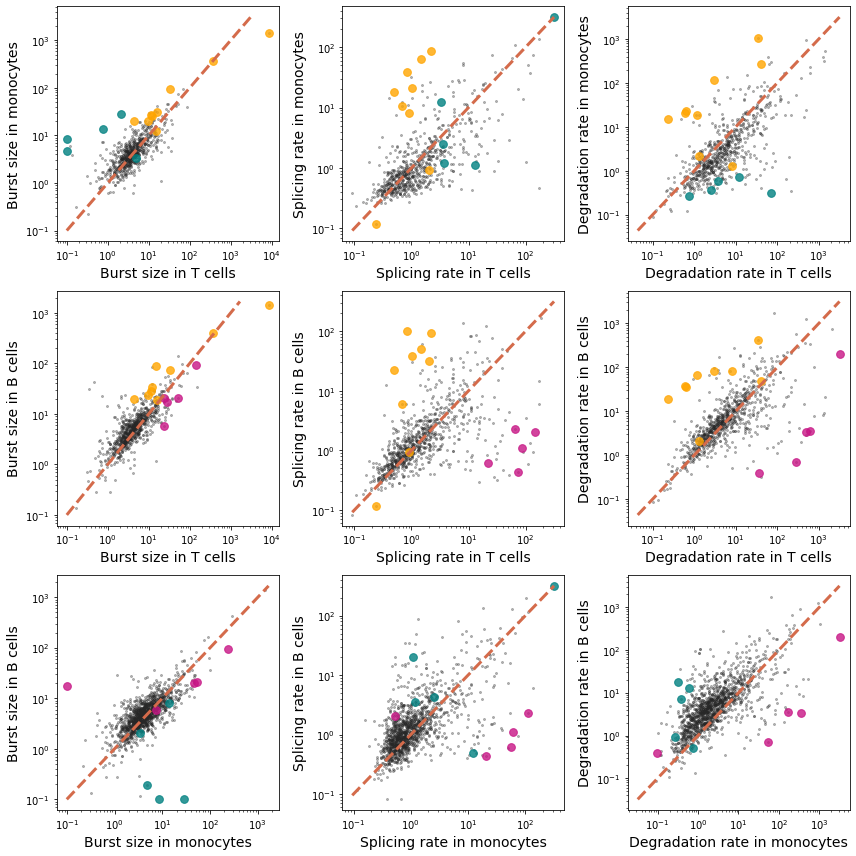

In [1238]:
fig1,ax1 = plt.subplots(3,3,figsize=(12,12))
for pair_index,pair in enumerate(pbmc_pairs):
    plot_marker_gene_pairs(sr_arr_pbmc,pair,pbmc_markers,pbmc_celltype_names_labels,ax1[pair_index])
fig1.tight_layout()
fig1.savefig('./'+figdir+'/celltype_diffs_pbmc.png',dpi=600)

### Allen

In [1317]:
pair = [0,1]

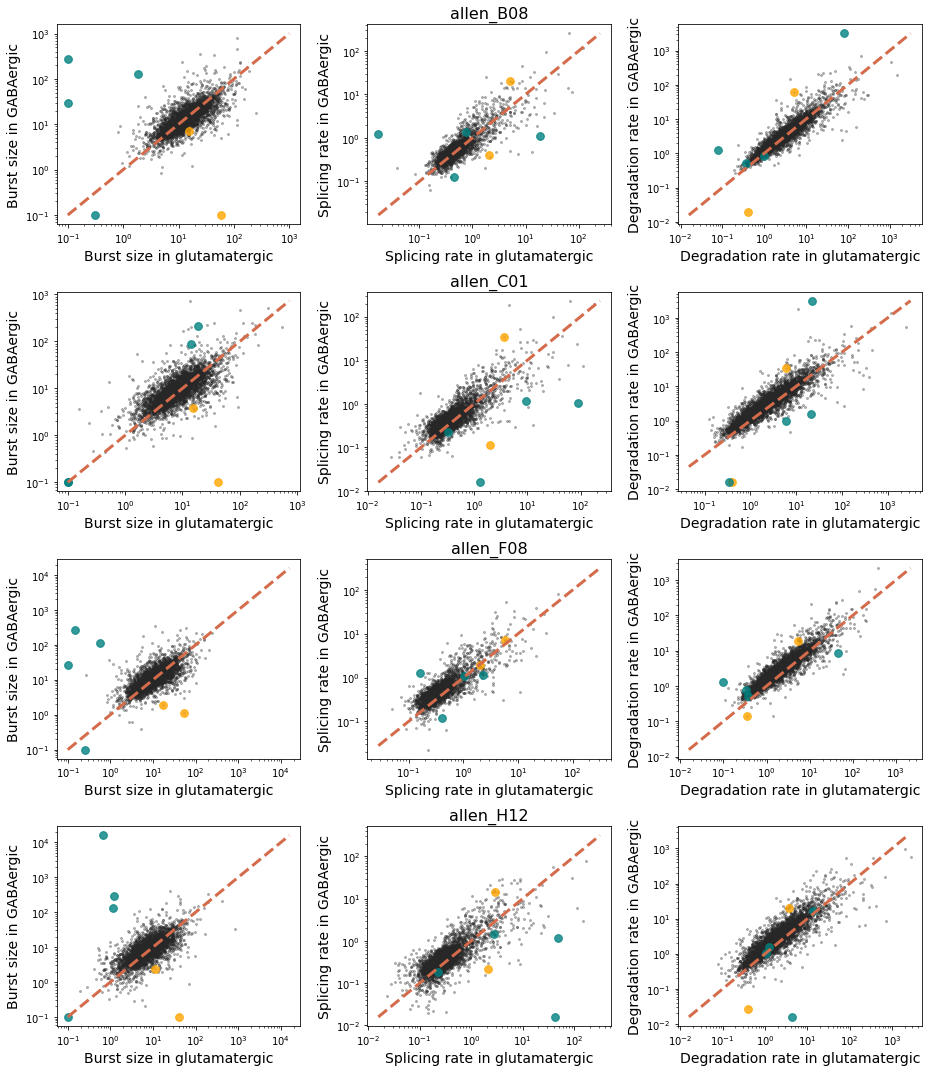

In [1318]:
fig1,ax1 = plt.subplots(4,3,figsize=(13,15))
for k,celltype_datasets in enumerate(allen_celltypes):
    sr_arr_allen = [monod.analysis.load_search_results('./fits/'+allen_celltype_batch_dir+'/'+x+'/Bursty_Poisson_1x1/grid_scan_results_upd.res') for x in celltype_datasets]
    plot_marker_gene_pairs(sr_arr_allen,pair,allen_markers,allen_celltype_names_labels,ax1[k])
    ax1[k,1].set_title(allen_celltype_datasets[k],fontsize=aesthetics['fontsize_body_title'])
fig1.tight_layout()
fig1.savefig('./'+figdir+'/celltype_diffs_allen.png',dpi=600)

## Panel b: relationships between modulation patterns

In [1334]:
def plot_marker_gene_pair_differences(sr_arr,pair,markers,celltype_names,ax1,omit_title=False):
    gn = sr_arr[0].gene_names
    n_genes = len(gn)

    gf_rej = (~sr_arr[pair[1]].rejected_genes) & (~sr_arr[pair[0]].rejected_genes)

    gf_mark_ = [np.where(gn == x)[0][0] for x in markers[pair[0]]]
    gf_mark_pop_0 = np.zeros(n_genes,dtype=bool)
    gf_mark_pop_0[gf_mark_] = True


    gf_mark_ = [np.where(gn == x)[0][0] for x in markers[pair[1]]]
    gf_mark_pop_1 = np.zeros(n_genes,dtype=bool)
    gf_mark_pop_1[gf_mark_] = True
    
    parameter_pairs = [[0,1],[0,2],[1,2]]
    for k,param_pair in enumerate(parameter_pairs):
        x = (sr_arr[pair[1]].phys_optimum[:,param_pair[0]] - sr_arr[pair[0]].phys_optimum[:,param_pair[0]])/np.log10(2)
        y = (sr_arr[pair[1]].phys_optimum[:,param_pair[1]] - sr_arr[pair[0]].phys_optimum[:,param_pair[1]])/np.log10(2)
        ax1[k].scatter(x[gf_rej],y[gf_rej],
                       s=aesthetics['celltype_diffs_ms'],
                       c=aesthetics['celltype_diffs_gene_color'],
                       alpha=aesthetics['celltype_diffs_gene_alpha'])
        ax1[k].scatter(x[gf_mark_pop_0],y[gf_mark_pop_0],
                       s=aesthetics['celltype_marker_ms'],
                       c=aesthetics['celltype_colors'][pair[0]],
                       alpha=aesthetics['celltype_marker_alpha'])
        ax1[k].scatter(x[gf_mark_pop_1],y[gf_mark_pop_1],
                       s=aesthetics['celltype_marker_ms'],
                       c=aesthetics['celltype_colors'][pair[1]],
                       alpha=aesthetics['celltype_marker_alpha'])
        ax1[k].set_xlabel(r'$\log_2$FC ('+param_names[param_pair[0]].lower()+')',fontsize=aesthetics['fontsize_body_axes'])
        ax1[k].set_ylabel(r'$\log_2$FC ('+param_names[param_pair[1]].lower()+')',fontsize=aesthetics['fontsize_body_axes'])
        xl = [x.min(),y.max()]        
        ax1[k].plot(xl,xl,'--',color=aesthetics['identity_line_color'],linewidth=aesthetics['identity_lw'],zorder=200)
        rho_ = np.corrcoef(x[gf_rej],y[gf_rej])[0,1]
        ax1[k].text(.05,.85,r'$\rho$ = {:.2f}'.format(rho_),fontsize=aesthetics['fontsize_body_title'],transform=ax1[k].transAxes)
    if not omit_title:
        ax1[1].set_title('Change from {} to {}'.format(celltype_names[pair[0]],celltype_names[pair[1]]),
                     fontsize=aesthetics['fontsize_body_title'])

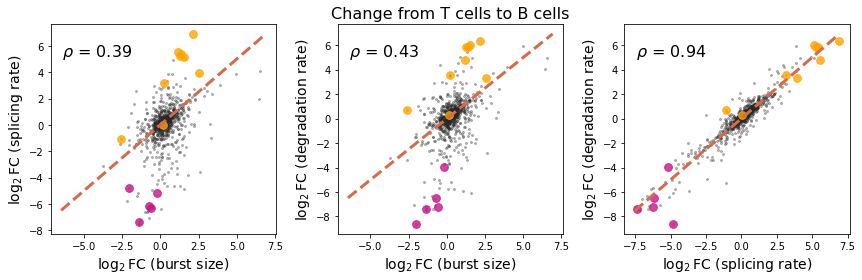

In [1335]:
pbmc_pairs = [[0,1],[0,2],[1,2]]
pair = pbmc_pairs[1]
fig1,ax1 = plt.subplots(1,3,figsize=(12,4))
plot_marker_gene_pair_differences(sr_arr_pbmc,pair,pbmc_markers,pbmc_celltype_names_labels,ax1)
fig1.tight_layout()
fig1.savefig('./'+figdir+'/celltype_param_covar_pbmc_subset.png',dpi=600)

### Supplements to 4b

#### PBMC

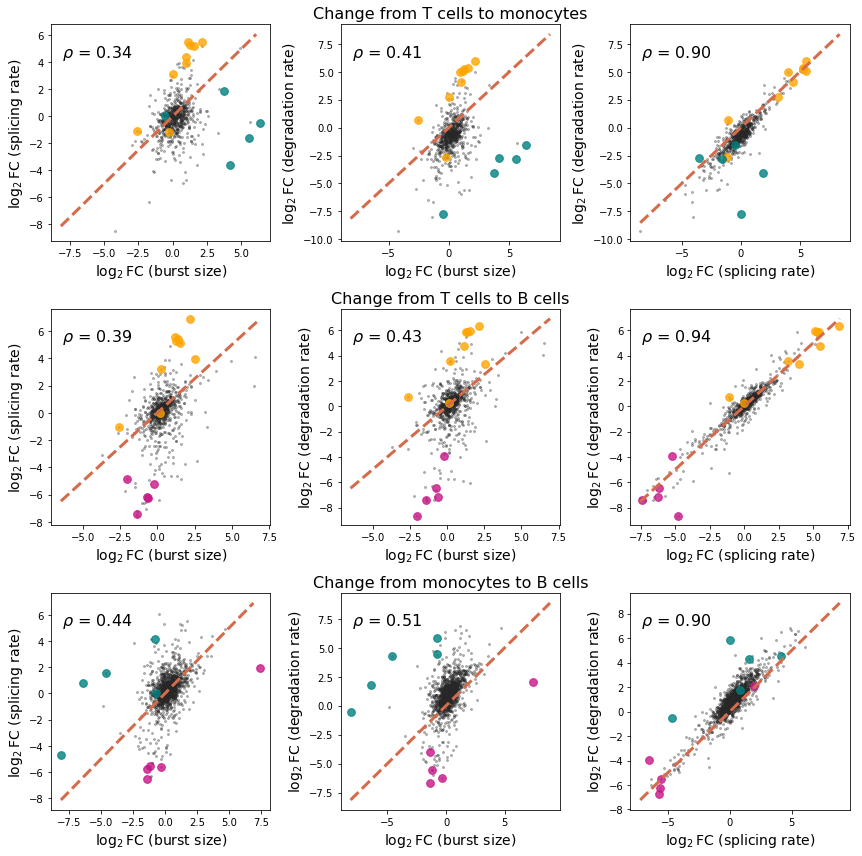

In [1336]:
fig1,ax1 = plt.subplots(3,3,figsize=(12,12))
for pair_index,pair in enumerate(pbmc_pairs):
    plot_marker_gene_pair_differences(sr_arr_pbmc,pair,pbmc_markers,pbmc_celltype_names_labels,ax1[pair_index])
fig1.tight_layout()
fig1.savefig('./'+figdir+'/celltype_param_covar_pbmc.png',dpi=600)

#### Allen

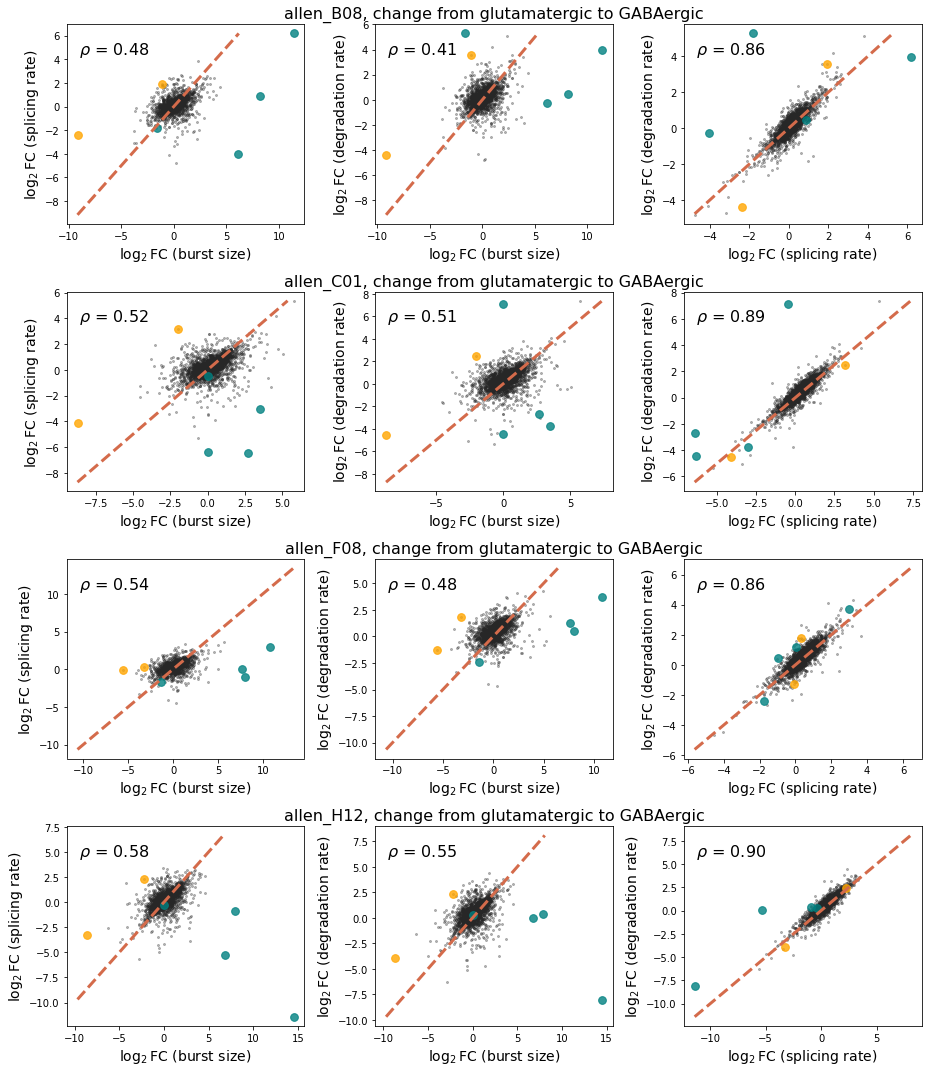

In [1337]:
fig1,ax1 = plt.subplots(4,3,figsize=(13,15))
pair = [0,1]
for k,celltype_datasets in enumerate(allen_celltypes):
    sr_arr_allen = [monod.analysis.load_search_results('./fits/'+allen_celltype_batch_dir+'/'+x+'/Bursty_Poisson_1x1/grid_scan_results_upd.res') for x in celltype_datasets]
    plot_marker_gene_pair_differences(sr_arr_allen,pair,allen_markers,allen_celltype_names_labels,ax1[k],omit_title=True)
    ax1[k,1].set_title(allen_celltype_datasets[k] + ', change from {} to {}'.format(\
                        allen_celltype_names_labels[0],allen_celltype_names_labels[1]),fontsize=aesthetics['fontsize_body_title'])
fig1.tight_layout()
fig1.savefig('./'+figdir+'/celltype_param_covar_allen.png',dpi=600)


## Panel c: Burst size and frequency modulation as explanatory mechanisms

In [1408]:
def plot_marker_gene_bs_k_diffs(sr_arr,pair,markers,celltype_names,ax1):
    gn = sr_arr[0].gene_names
    n_genes = len(gn)

    gf_rej = (~sr_arr[pair[1]].rejected_genes) & (~sr_arr[pair[0]].rejected_genes)
    fc_par = (sr_arr[pair[1]].phys_optimum-sr_arr[pair[0]].phys_optimum)/np.log10(2)

    gf_mark_ = [np.where(gn == x)[0][0] for x in markers[pair[0]]]
    gf_mark_pop_0 = np.zeros(n_genes,dtype=bool)
    gf_mark_pop_0[gf_mark_] = True


    gf_mark_ = [np.where(gn == x)[0][0] for x in markers[pair[1]]]
    gf_mark_pop_1 = np.zeros(n_genes,dtype=bool)
    gf_mark_pop_1[gf_mark_] = True
    
    x = (sr_arr[pair[1]].phys_optimum[:,0] - sr_arr[pair[0]].phys_optimum[:,0])/np.log10(2)
    y = -(sr_arr[pair[1]].phys_optimum[:,1] - sr_arr[pair[0]].phys_optimum[:,1])/np.log10(2)

#     print(x[gf_mark_pop_0]+y[gf_mark_pop_0])
#     print(x[gf_mark_pop_1]+y[gf_mark_pop_1])
    ax1.scatter(x[gf_rej],y[gf_rej],
                   s=aesthetics['celltype_diffs_ms'],
                   c=aesthetics['celltype_diffs_gene_color'],
                   alpha=aesthetics['celltype_diffs_gene_alpha'])
    ax1.scatter(x[gf_mark_pop_0],y[gf_mark_pop_0],
                   s=aesthetics['celltype_marker_ms'],
                   c=aesthetics['celltype_colors'][pair[0]],
                   alpha=aesthetics['celltype_marker_alpha'])
    ax1.scatter(x[gf_mark_pop_1],y[gf_mark_pop_1],
                   s=aesthetics['celltype_marker_ms'],
                   c=aesthetics['celltype_colors'][pair[1]],
                   alpha=aesthetics['celltype_marker_alpha'])
    ax1.set_xlabel(r'$\log_2$FC (burst size)',fontsize=aesthetics['fontsize_body_axes'])
    ax1.set_ylabel(r'$\log_2$FC (burst frequency)',fontsize=aesthetics['fontsize_body_axes'])
    
    xl = np.asarray([-4,4])
    ax1.plot(xl,-xl,'-.',color=aesthetics['partition_line_color'],linewidth=aesthetics['identity_lw'],zorder=200)
#     ax1.set_xlim([-2.5,2.5])
#     ax1.set_ylim([-2.5,2.5])
#     ax1.set_xlim([-8,8])
#     ax1.set_ylim([-8,8])
    ax1.axis('equal')
    ax1.set_title('Change from {} to {}'.format(celltype_names[pair[0]],celltype_names[pair[1]]),
                     fontsize=aesthetics['fontsize_body_title'])

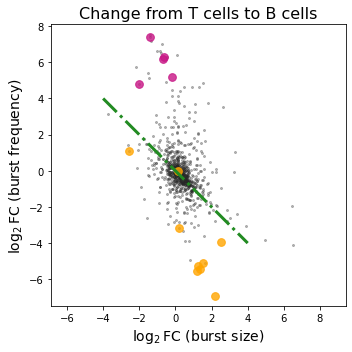

In [1409]:
pbmc_pairs = [[0,1],[0,2],[1,2]]
pair = pbmc_pairs[1]
fig1,ax1 = plt.subplots(1,1,figsize=(5,5))
plot_marker_gene_bs_k_diffs(sr_arr_pbmc,pair,pbmc_markers,pbmc_celltype_names_labels,ax1)
fig1.tight_layout()
fig1.savefig('./'+figdir+'/celltype_param_bs_k_pbmc_subset.png',dpi=600)

### Supplements to 4c

#### PBMC

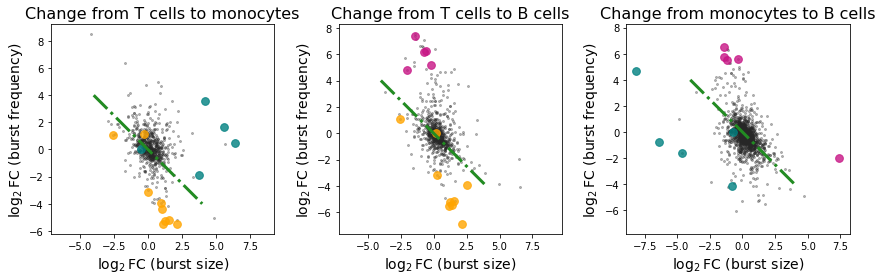

In [1410]:
fig1,ax1 = plt.subplots(1,3,figsize=(12,4))
for pair_index,pair in enumerate(pbmc_pairs):
    plot_marker_gene_bs_k_diffs(sr_arr_pbmc,pair,pbmc_markers,pbmc_celltype_names_labels,ax1[pair_index])
fig1.tight_layout()
fig1.savefig('./'+figdir+'/celltype_param_bs_k_pbmc.png',dpi=600)

#### Allen

In [1411]:
allen_markers

[['Slc17a7', 'Slc17a6'], ['Gad1', 'Gad2', 'Slc32a1', 'Slc6a5']]

What's the deal with Slc6a5?

In [1412]:
pair = [0,1]

for k,celltype_datasets in enumerate(allen_celltypes):
    print(allen_celltype_datasets[k])
    sd_arr_allen = [monod.analysis.load_search_data('./fits/'+allen_celltype_batch_dir+'/'+x+'/raw.sd') for x in celltype_datasets]
    gn = sd_arr_allen[0].gene_names
    
    gf_mark_ = [np.where(gn == x)[0][0] for x in allen_markers[pair[0]]]
    gf_mark_glu = np.zeros(n_genes,dtype=bool)
    gf_mark_glu[gf_mark_] = True

    gf_mark_ = [np.where(gn == x)[0][0] for x in allen_markers[pair[1]]]
    gf_mark_gaba = np.zeros(n_genes,dtype=bool)
    gf_mark_gaba[gf_mark_] = True
    
    print(f'\tGlu marker mean in Glu: {sd_arr_allen[0].layers[1,gf_mark_glu].mean(1).round(1)}')
    print(f'\tGlu marker mean in GABA: {sd_arr_allen[1].layers[1,gf_mark_glu].mean(1).round(1)}')
    print(f'\tGABA marker mean in Glu: {sd_arr_allen[0].layers[1,gf_mark_gaba].mean(1).round(1)}')
    print(f'\tGABA marker mean in GABA: {sd_arr_allen[1].layers[1,gf_mark_gaba].mean(1).round(1)}')


allen_B08
	Glu marker mean in Glu: [ 0.8 38.3]
	Glu marker mean in GABA: [0.  1.6]
	GABA marker mean in Glu: [0.5 0.1 0.5 0. ]
	GABA marker mean in GABA: [61.9 15.9 42.1  0. ]
allen_C01
	Glu marker mean in Glu: [ 0.7 29.6]
	Glu marker mean in GABA: [0.  1.6]
	GABA marker mean in Glu: [0.3 0.1 0.4 0. ]
	GABA marker mean in GABA: [38.  10.1 25.8  0. ]
allen_F08
	Glu marker mean in Glu: [ 0.9 41.4]
	Glu marker mean in GABA: [0.  2.1]
	GABA marker mean in Glu: [0.4 0.1 0.5 0. ]
	GABA marker mean in GABA: [58.2 13.2 41.4  0. ]
allen_H12
	Glu marker mean in Glu: [ 0.8 27.8]
	Glu marker mean in GABA: [0. 1.]
	GABA marker mean in Glu: [0.2 0.  0.3 0. ]
	GABA marker mean in GABA: [51.4  9.3 34.4  0. ]


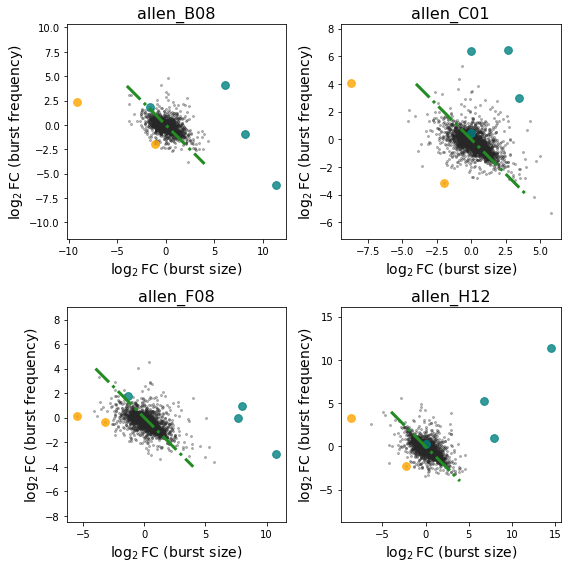

In [1413]:
fig1,ax1 = plt.subplots(2,2,figsize=(8,8))
pair = [0,1]
for k,celltype_datasets in enumerate(allen_celltypes):
    axloc = np.unravel_index(k,(2,2))
    sr_arr_allen = [monod.analysis.load_search_results('./fits/'+allen_celltype_batch_dir+'/'+x+'/Bursty_Poisson_1x1/grid_scan_results_upd.res') for x in celltype_datasets]
    plot_marker_gene_bs_k_diffs(sr_arr_allen,pair,allen_markers,allen_celltype_names_labels,ax1[axloc])
    ax1[axloc].set_title(allen_celltype_datasets[k] ,fontsize=aesthetics['fontsize_body_title'])
fig1.tight_layout()
fig1.savefig('./'+figdir+'/celltype_param_bs_k_allen.png',dpi=600)


## Panel 4d: Statistical testing of differences between neural cell types

In [1186]:
sr_baseline_arr = [monod.analysis.load_search_results('./fits/'+batch_dirs[3]+'/'+x+'/Bursty_Poisson_20x21/grid_scan_results_upd.res') for x in dataset_v3_list[3]]


In [1195]:
samp_optima = np.asarray([x.samp_optimum for x in sr_baseline_arr])
samp_optimum_inferred = samp_optima.mean(0)
print(samp_optimum_inferred)

[-6.10526316 -0.5625    ]


In [1196]:
# samp_optimum_inferred